# TFM - CC CASTELNOU - ENERGY-PRICE CURVE PREDICTION


## 1. INTRODUCTION

In this Notebook several ENERGY-PRICE CURVE predicted models will be created.

Data considered as input for this notebook is the following:

+ **OMIE bid curves** from November 1, 2019 to October 31, 2020 will be considered as the baseline data information. This info comes from "OMIE_PALOS1_112019_102020.csv", created previously in "02_RawData_OMIE_UNITS.ipynb" notebook.


+ **OMIE marginal price** will be considered also. This info comes from "MARGINAL_PRICES_SPAIN.csv", created in "03_RawData_OMIE_MargPrice.ipynb".


+ **Natural gas price** will be considered also. This info comes from "df_NaturalGas_Price.csv", created in "04_RawData_NGPrice.ipynb".



The notebook is divided in the following sections:

+ **RETRIEVING, EXPLORING AND PLOTTING OMIE DATA INFORMATION.** In this section, raw data are explored and plotted to process it afterwards.


+ **DATA WRANGLING.** In this section, data are processed to be a useful input to the ML models, splitting the information into TRAIN, VALIDATION, and TEST sets.


+ **ML MODELS.** In this section, ML models are created and stored locally into Pickle files.


+ **AREA METRIC CALCULATION.** In this section, a metric based on block areas is defined in order to evaluate properly the model results, and compare them with the naive model.


+ **NAIVE MODEL.** In this section a naive model is created as a baseline to compare the ML models. This naive model considers the bid prediction equal to the corresponding 24h lagged bid. 


+ **RESULT SUMMARY AND CONCLUSION.** In this section comparison of naive model and different models and the concluison of the work is presented. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta

#These functions have been defined in "TFM_PredCurve_Tools.py" and are used for data plotting and wrangling
from TFM_PredCurve_Tools import data_date_hour_info, convert_to_df_curve, days_25h_23h
from TFM_PredCurve_Tools import data_report, data_report_total, missing_dates, bid_hour_summary
from TFM_PredCurve_Tools import plot_bid_curve, plot_marginal_price, plot_bid_margprice, plot_bid_margprice_day
from TFM_PredCurve_Tools import plot_bid_curve_day, plot_marginal_price_day, myplot, plot_24bids
from TFM_PredCurve_Tools import plot_bid_timeperiod, plot_bid_timeperiod_line
from TFM_PredCurve_Tools import plot_energy_timeperiod, plot_energy_timeperiod_line
from TFM_PredCurve_Tools import df_structure_24h, area_pred_curve_summary, df_pred_summary
from TFM_PredCurve_Tools import MAE_model, RMSE_model

In [2]:
#Display options
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

First of all, unit, and the paths for the data input and for the pickle files (where the models already fitted are stored) are defined.

In [3]:
unit = 'CASTELNOU'
unit_path = './Data_Input/'
output_path = './Data_Output/'

unit_pkl = unit + '_MargP'
path_pkl = './Pickle_Models/'

## 2. RETRIEVING, EXPLORING AND PLOTTING OMIE DATA INFORMATION

### 2.1. RETRIEVING DATA INFORMATION

#### 2.1.1.  RETRIEVING DATA FROM BID CURVES

In [4]:
df_unit = pd.read_csv(unit_path + 'OMIE_' + unit + '_112019_102020.csv',index_col=0)

In [5]:
#The start and end date of the OMIE period is defined. Note not all the units have data at the start or end of
#the whole time period considered

df_unit_start_date = pd.to_datetime('2019-11-01')
df_unit_end_date = pd.to_datetime('2020-10-31')

In [6]:
df_unit.head()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
0,6359428,3,CTNU,C.C. CASTELNOU,VNO,797.80,2020,6,16,8,1,0.10,12.00
1,6359428,3,CTNU,C.C. CASTELNOU,VNO,797.80,2020,6,16,8,2,180.00,785.80
2,6359428,3,CTNU,C.C. CASTELNOU,VNO,797.80,2020,6,16,9,1,0.10,45.00
3,6359428,3,CTNU,C.C. CASTELNOU,VNO,797.80,2020,6,16,9,2,180.00,752.80
4,6359428,3,CTNU,C.C. CASTELNOU,VNO,797.80,2020,6,16,10,1,0.10,51.00


In [7]:
df_unit.shape

(16343, 13)

In [8]:
df_unit.columns

Index(['Bid_Code', 'Num_Version', 'Bid_Unit', 'Unit_Description', 'Sell_Buy',
       'Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price',
       'Energy'],
      dtype='object')

In [9]:
df_unit.tail()

,Bid_Code,Num_Version,Bid_Unit,Unit_Description,Sell_Buy,Pot_max,Year,Month,Day,Period,Block,Price,Energy
16338,6556087,1,CTNU,C.C. CASTELNOU,VNO,797.80,2020,10,31,24,3,22.50,33.60
16339,6556087,1,CTNU,C.C. CASTELNOU,VNO,797.80,2020,10,31,24,4,25.00,33.60
16340,6556087,1,CTNU,C.C. CASTELNOU,VNO,797.80,2020,10,31,24,5,27.50,33.60
16341,6556087,1,CTNU,C.C. CASTELNOU,VNO,797.80,2020,10,31,24,6,30.00,33.60
16342,6556087,1,CTNU,C.C. CASTELNOU,VNO,797.80,2020,10,31,24,7,95.00,49.30


In [10]:
df_unit.describe()

,Bid_Code,Num_Version,Pot_max,Year,Month,Day,Period,Block,Price,Energy
count,"16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00"
mean,"6,458,340.90",0.20,797.80,"2,020.00",8.25,16.55,15.49,3.79,37.38,103.72
std,"56,522.56",0.56,0.00,0.00,1.29,8.75,5.60,2.12,33.05,133.19
min,"6,359,428.00",0.00,797.80,"2,020.00",6.00,1.00,1.00,1.00,0.10,8.00
25%,"6,408,012.00",0.00,797.80,"2,020.00",7.00,9.00,11.00,2.00,22.50,32.40
50%,"6,457,709.00",0.00,797.80,"2,020.00",8.00,17.00,16.00,4.00,27.50,49.30
75%,"6,506,282.00",0.00,797.80,"2,020.00",9.00,24.00,20.00,6.00,30.00,108.80
max,"6,556,087.00",5.00,797.80,"2,020.00",10.00,31.00,25.00,9.00,180.00,797.80


In [11]:
df_unit.dtypes

Bid_Code              int64
Num_Version           int64
Bid_Unit             object
Unit_Description     object
Sell_Buy             object
Pot_max             float64
Year                  int64
Month                 int64
Day                   int64
Period                int64
Block                 int64
Price               float64
Energy              float64
dtype: object

Converting **df_unit** into a dataframe with only the information that will be needed for plotting bid curves, including **Date**, **Weekday**, and the total energy (**Energy_tot**) that is the cummulative sum of **Energy**, (energy offered for each block or delta energy), needed to plot bid curves. Function **convert_to_df_curve** is defined in **TFM_PredCurve_Tools.py**.

In [12]:
df_curve = convert_to_df_curve(df_unit)

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Date']= pd.to_datetime(df_curve[['Year', 'Month', 'Day']])
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curve['Weekday'] = df_curve['Date'].apply(lambda x: x.weekday())
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [13]:
df_curve.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
0,797.80,2020,6,16,8,1,0.10,12.00,2020-06-16,Tuesday,12.00
1,797.80,2020,6,16,8,2,180.00,785.80,2020-06-16,Tuesday,797.80
2,797.80,2020,6,16,9,1,0.10,45.00,2020-06-16,Tuesday,45.00
3,797.80,2020,6,16,9,2,180.00,752.80,2020-06-16,Tuesday,797.80
4,797.80,2020,6,16,10,1,0.10,51.00,2020-06-16,Tuesday,51.00


Several checkings can be done like the following:

In [14]:
#Checking that the maximum bid price is 180.3€ (maximum value by law when data were retreived)
df_curve['Price'].max()

180.0

In [15]:
#Second Maximum Price (not considering the maximum of 180.3€)
df_curve[df_curve['Price']!=df_curve['Price'].max()]['Price'].max()

99.0

In [16]:
#Date when the bid price was the maximum feasible
df_curve[df_curve['Price']==df_curve[df_curve['Price']!=df_curve['Price'].max()]['Price'].max()]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
78,797.80,2020,6,18,9,9,99.00,9.30,2020-06-18,Thursday,797.80
87,797.80,2020,6,18,10,9,99.00,9.30,2020-06-18,Thursday,797.80
96,797.80,2020,6,18,11,9,99.00,9.30,2020-06-18,Thursday,797.80
105,797.80,2020,6,18,12,9,99.00,9.30,2020-06-18,Thursday,797.80
114,797.80,2020,6,18,13,9,99.00,9.30,2020-06-18,Thursday,797.80
123,797.80,2020,6,18,14,9,99.00,9.30,2020-06-18,Thursday,797.80
132,797.80,2020,6,18,15,9,99.00,9.30,2020-06-18,Thursday,797.80
141,797.80,2020,6,18,16,9,99.00,9.30,2020-06-18,Thursday,797.80
150,797.80,2020,6,18,17,9,99.00,9.30,2020-06-18,Thursday,797.80
159,797.80,2020,6,18,18,9,99.00,9.30,2020-06-18,Thursday,797.80


In [17]:
#Checking the minimum bid price
df_curve['Price'].min()

0.1

In [18]:
#Second Minimum Price (not considering the minimum of 1.13€)
df_curve[df_curve['Price']!=df_curve['Price'].min()]['Price'].min()

20.0

In [19]:
#Date when the bid price was the second minimum
df_curve[df_curve['Price']==df_curve[df_curve['Price']!=df_curve['Price'].min()]['Price'].min()]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot
586,797.80,2020,6,22,15,2,20.00,63.00,2020-06-22,Monday,243.00
591,797.80,2020,6,22,16,2,20.00,63.00,2020-06-22,Monday,243.00
596,797.80,2020,6,22,17,2,20.00,63.00,2020-06-22,Monday,243.00
601,797.80,2020,6,22,18,2,20.00,63.00,2020-06-22,Monday,243.00
606,797.80,2020,6,22,19,2,20.00,63.00,2020-06-22,Monday,243.00
...,...,...,...,...,...,...,...,...,...,...,...
16308,797.80,2020,10,31,20,1,20.00,180.00,2020-10-31,Saturday,180.00
16315,797.80,2020,10,31,21,1,20.00,180.00,2020-10-31,Saturday,180.00
16322,797.80,2020,10,31,22,1,20.00,180.00,2020-10-31,Saturday,180.00
16329,797.80,2020,10,31,23,1,20.00,180.00,2020-10-31,Saturday,180.00


#### 2.1.2. RETRIEVING DATA FROM MARGINAL PRICE (MCP)

In [20]:
df_marg_price = pd.read_csv(unit_path + 'MARGINAL_PRICES_SPAIN.csv',index_col=0)

In [21]:
df_marg_price.head()

,Year,Month,Day,Period,Marg_Price,Date
0,2019,1,1,1,66.88,2019-01-01
1,2019,1,1,2,66.88,2019-01-01
2,2019,1,1,3,66.00,2019-01-01
3,2019,1,1,4,63.64,2019-01-01
4,2019,1,1,5,58.85,2019-01-01


In [22]:
#Starting and ending date for marginal price data
df_marg_price['Date'].min(), df_marg_price['Date'].max()

('2019-01-01', '2020-12-31')

In [23]:
#Obtaining the index for the starting date of df_curve in df_mar_price
marg_price_start_index = df_marg_price[(df_marg_price['Date']== str(df_curve['Date'].min())[0:10]) &
              (df_marg_price['Period']== df_marg_price['Period'].min())].index[0]

marg_price_start_index

12767

In [24]:
#Obtaining the index for the ending date of df_curve in df_mar_price
marg_price_end_index = df_marg_price[(df_marg_price['Date']== str(df_curve['Date'].max())[0:10]) &
              (df_marg_price['Period']== 24)].index[0]

marg_price_end_index

16079

In [25]:
#Picking only the marginal price information corresponding to the time period of the OMIE bid curve information

df_price = df_marg_price[marg_price_start_index:marg_price_end_index+1]

In [26]:
df_price.reset_index(drop=True,inplace=True)

In [27]:
df_price.describe()

,Year,Month,Day,Period,Marg_Price
count,"3,313.00","3,313.00","3,313.00","3,313.00","3,313.00"
mean,"2,020.00",8.23,16.65,12.50,36.86
std,0.00,1.31,8.79,6.93,8.31
min,"2,020.00",6.00,1.00,1.00,1.95
25%,"2,020.00",7.00,9.00,7.00,31.07
50%,"2,020.00",8.00,17.00,13.00,37.50
75%,"2,020.00",9.00,24.00,19.00,41.93
max,"2,020.00",10.00,31.00,25.00,59.07


In [28]:
df_price.head()

,Year,Month,Day,Period,Marg_Price,Date
0,2020,6,16,1,32.40,2020-06-16
1,2020,6,16,2,30.39,2020-06-16
2,2020,6,16,3,28.32,2020-06-16
3,2020,6,16,4,28.24,2020-06-16
4,2020,6,16,5,28.32,2020-06-16


In [29]:
df_price.tail()

,Year,Month,Day,Period,Marg_Price,Date
3308,2020,10,31,20,41.45,2020-10-31
3309,2020,10,31,21,44.83,2020-10-31
3310,2020,10,31,22,44.82,2020-10-31
3311,2020,10,31,23,40.90,2020-10-31
3312,2020,10,31,24,39.75,2020-10-31


In [30]:
#Sorting the columns
df_price[['Year', 'Month', 'Day', 'Period','Marg_Price']].head()

,Year,Month,Day,Period,Marg_Price
0,2020,6,16,1,32.40
1,2020,6,16,2,30.39
2,2020,6,16,3,28.32
3,2020,6,16,4,28.24
4,2020,6,16,5,28.32


Plotting the marginal price distribution during the studied time period.

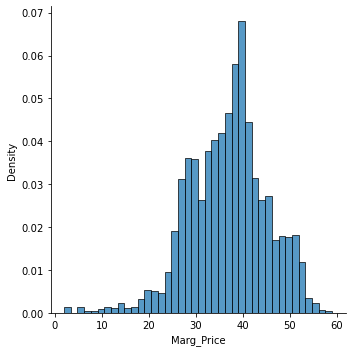

In [31]:
sns.displot(data=df_price, x='Marg_Price',stat='density');

#### 2.1.3. MERGING DATAFRAMES

Now dataframes with the bid curve and marginal price data are merged.

In [32]:
df_curve = df_curve.merge(df_price[['Year', 'Month', 'Day', 'Period','Marg_Price']], how = 'left')
df_curve

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price
0,797.80,2020,6,16,8,1,0.10,12.00,2020-06-16,Tuesday,12.00,34.38
1,797.80,2020,6,16,8,2,180.00,785.80,2020-06-16,Tuesday,797.80,34.38
2,797.80,2020,6,16,9,1,0.10,45.00,2020-06-16,Tuesday,45.00,35.21
3,797.80,2020,6,16,9,2,180.00,752.80,2020-06-16,Tuesday,797.80,35.21
4,797.80,2020,6,16,10,1,0.10,51.00,2020-06-16,Tuesday,51.00,36.21
...,...,...,...,...,...,...,...,...,...,...,...,...
16338,797.80,2020,10,31,24,3,22.50,33.60,2020-10-31,Saturday,247.20,39.75
16339,797.80,2020,10,31,24,4,25.00,33.60,2020-10-31,Saturday,280.80,39.75
16340,797.80,2020,10,31,24,5,27.50,33.60,2020-10-31,Saturday,314.40,39.75
16341,797.80,2020,10,31,24,6,30.00,33.60,2020-10-31,Saturday,348.00,39.75


In [33]:
#Checking NaN
df_curve.isnull().values.any()

False

In [34]:
df_curve.describe()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Energy_tot,Marg_Price
count,"16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00","16,343.00"
mean,797.80,"2,020.00",8.25,16.55,15.49,3.79,37.38,103.72,345.39,38.24
std,0.00,0.00,1.29,8.75,5.60,2.12,33.05,133.19,166.97,8.16
min,797.80,"2,020.00",6.00,1.00,1.00,1.00,0.10,8.00,8.00,1.95
25%,797.80,"2,020.00",7.00,9.00,11.00,2.00,22.50,32.40,240.00,33.19
50%,797.80,"2,020.00",8.00,17.00,16.00,4.00,27.50,49.30,302.40,38.98
75%,797.80,"2,020.00",9.00,24.00,20.00,6.00,30.00,108.80,397.30,43.50
max,797.80,"2,020.00",10.00,31.00,25.00,9.00,180.00,797.80,797.80,59.07


#### 2.1.4. RETRIEVING DATA FROM NATURAL GAS PRICE

In [35]:
df_NG_price = pd.read_csv(unit_path + 'df_NaturalGas_Price.csv',index_col=0)

In [36]:
df_NG_price.head()

,Date,Year,Month,Day,NG_Price
0,2008-04-14,2008,4,14,10.03
1,2008-04-15,2008,4,15,10.16
2,2008-04-16,2008,4,16,10.11
3,2008-04-17,2008,4,17,10.27
4,2008-04-18,2008,4,18,10.08


In [37]:
df_NG_price.tail()

,Date,Year,Month,Day,NG_Price
3284,2021-03-30,2021,3,30,2.55
3285,2021-03-31,2021,3,31,2.52
3286,2021-04-01,2021,4,1,2.52
3287,2021-04-05,2021,4,5,2.43
3288,2021-04-06,2021,4,6,2.44


In [38]:
df_NG_price.dtypes

Date         object
Year          int64
Month         int64
Day           int64
NG_Price    float64
dtype: object

In [39]:
#Picking the natural gas prices for the same time period of the bid curve information

NG_price_start = df_NG_price[(df_NG_price['Date']== str(df_curve['Date'].min()+timedelta(1))[0:10])].index[0]

NG_price_start

3090

In [40]:
#There is no natural gas information for the last day in bid curve information, so the previous date is chosen

NG_price_end = df_NG_price[(df_NG_price['Date']=='2020-10-30')].index[0]

NG_price_end

3184

In [41]:
df_NG_price_unit = df_NG_price[NG_price_start:NG_price_end+1]
df_NG_price_unit

,Date,Year,Month,Day,NG_Price
3090,2020-06-17,2020,6,17,1.55
3091,2020-06-18,2020,6,18,1.51
3092,2020-06-19,2020,6,19,1.49
3093,2020-06-22,2020,6,22,1.64
3094,2020-06-23,2020,6,23,1.61
...,...,...,...,...,...
3180,2020-10-26,2020,10,26,3.14
3181,2020-10-27,2020,10,27,3.07
3182,2020-10-28,2020,10,28,3.14
3183,2020-10-29,2020,10,29,3.06


Plotting the natural gas price distribution during the studied time period.

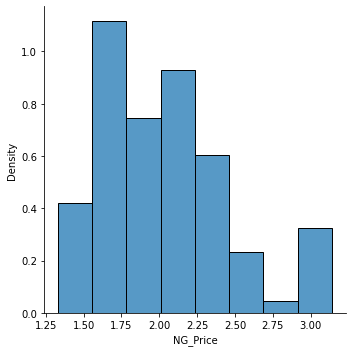

In [42]:
sns.displot(data=df_NG_price_unit, x='NG_Price',stat='density');

In [43]:
df_NG_price_unit.shape

(95, 5)

It is obvious that there are missing values, so NaN will be created when merging this dataframe with df_curve

#### 2.1.5. MERGING DATAFRAMES

In [44]:
df_curve = df_curve.merge(df_NG_price_unit[['Year', 'Month', 'Day', 'NG_Price']], how = 'left')
df_curve

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
0,797.80,2020,6,16,8,1,0.10,12.00,2020-06-16,Tuesday,12.00,34.38,nan
1,797.80,2020,6,16,8,2,180.00,785.80,2020-06-16,Tuesday,797.80,34.38,nan
2,797.80,2020,6,16,9,1,0.10,45.00,2020-06-16,Tuesday,45.00,35.21,nan
3,797.80,2020,6,16,9,2,180.00,752.80,2020-06-16,Tuesday,797.80,35.21,nan
4,797.80,2020,6,16,10,1,0.10,51.00,2020-06-16,Tuesday,51.00,36.21,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16338,797.80,2020,10,31,24,3,22.50,33.60,2020-10-31,Saturday,247.20,39.75,nan
16339,797.80,2020,10,31,24,4,25.00,33.60,2020-10-31,Saturday,280.80,39.75,nan
16340,797.80,2020,10,31,24,5,27.50,33.60,2020-10-31,Saturday,314.40,39.75,nan
16341,797.80,2020,10,31,24,6,30.00,33.60,2020-10-31,Saturday,348.00,39.75,nan


In [45]:
#Checking NaN in the new column
df_curve['NG_Price'].isnull().values.any()

True

In [46]:
#Checking NaN in the rest of the dataframe
df_curve[['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price', 'Energy',
       'Date', 'Weekday', 'Energy_tot', 'Marg_Price']].isnull().values.any()

False

In [47]:
#Filling NaN with the previous value in NG_Price columns (the only column with NaN)
df_curve['NG_Price'].fillna(method='ffill',inplace=True)
df_curve

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
0,797.80,2020,6,16,8,1,0.10,12.00,2020-06-16,Tuesday,12.00,34.38,nan
1,797.80,2020,6,16,8,2,180.00,785.80,2020-06-16,Tuesday,797.80,34.38,nan
2,797.80,2020,6,16,9,1,0.10,45.00,2020-06-16,Tuesday,45.00,35.21,nan
3,797.80,2020,6,16,9,2,180.00,752.80,2020-06-16,Tuesday,797.80,35.21,nan
4,797.80,2020,6,16,10,1,0.10,51.00,2020-06-16,Tuesday,51.00,36.21,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16338,797.80,2020,10,31,24,3,22.50,33.60,2020-10-31,Saturday,247.20,39.75,3.03
16339,797.80,2020,10,31,24,4,25.00,33.60,2020-10-31,Saturday,280.80,39.75,3.03
16340,797.80,2020,10,31,24,5,27.50,33.60,2020-10-31,Saturday,314.40,39.75,3.03
16341,797.80,2020,10,31,24,6,30.00,33.60,2020-10-31,Saturday,348.00,39.75,3.03


In [50]:
#Storing the DataFrame locally
#df_curve.to_csv(output_path + unit + '_DataFrame.csv')

### 2.2. EXPLORING DATA INFORMATION

In this section, the format of the bids are studied with the purpose of designing the best approach to modify the dataframe to use it as the best model input.

In [51]:
#Searching for NaN
df_curve.isnull().values.any()

True

In [52]:
df_curve.shape

(16343, 13)

In [53]:
#Using a funtion to check different bids for differents days and hours
data_date_hour_info(df_curve, '2020-10-31', 1)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
16223,797.80,2020,10,31,1,1,95.00,397.30,2020-10-31,Saturday,397.30,35.04,3.03


In [54]:
data_date_hour_info(df_curve,'2020-10-31',24)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
16336,797.80,2020,10,31,24,1,20.00,180.00,2020-10-31,Saturday,180.00,39.75,3.03
16337,797.80,2020,10,31,24,2,21.00,33.60,2020-10-31,Saturday,213.60,39.75,3.03
16338,797.80,2020,10,31,24,3,22.50,33.60,2020-10-31,Saturday,247.20,39.75,3.03
16339,797.80,2020,10,31,24,4,25.00,33.60,2020-10-31,Saturday,280.80,39.75,3.03
16340,797.80,2020,10,31,24,5,27.50,33.60,2020-10-31,Saturday,314.40,39.75,3.03
16341,797.80,2020,10,31,24,6,30.00,33.60,2020-10-31,Saturday,348.00,39.75,3.03
16342,797.80,2020,10,31,24,7,95.00,49.30,2020-10-31,Saturday,397.30,39.75,3.03


In this case, we can see a bid with 5 blocks, named from 1 to 5.

This way to name the blocks in the bids can be different from one unit to another, so it is important to determine the **type of bid** for the unit studied.

### TYPE OF BID

The first variable to determine the type of bid for a certain unit is the name of the block that appears in all the bids, (for bids with all blocks and for bids with only one block).

In [55]:
#Variable to include the number of the block that appears always (if there are more than one the minimum is chosen).
num_hours = df_curve.groupby(['Date','Period'])['Block'].count().value_counts().sum()
serie_block_all = df_curve.groupby(['Block'])['Period'].count()[df_curve.groupby(['Block'])['Period'].count() == num_hours]
serie_block_all = serie_block_all.reset_index()
block_all = serie_block_all['Block'].min()
block_all

1

The second variable that should be considered is the name of the maximum block.

In [56]:
#Variable to include the maximum number of blocks

block_max = df_curve['Block'].max()
block_max

9

When the name of the maximum block and the name of the block that appears in all bids is the same, the type of bid is called **A type**, it this condition is not fulfilled, the type of bid is called **B type**.

### BIDDING PERIODS REPORT

In this section a report of the bidding periods is determined. Note that it is possible that the unit is not working during the entire time period (12 months) consdered. If the bidding period is too sort the unit will not be studied.

In [57]:
dates = df_curve[(df_curve['Period']==df_curve.groupby('Period')['Date'].count().argmax()+1)
                 &(df_curve['Block']==block_all)]['Date'].tolist()

period = [dates[0]]
for x in range(len(dates)-1):
    if dates[x]+timedelta(1)!= dates[x+1]:
        period.append(dates[x])
        period.append(dates[x+1])
period.append(dates[-1])

for x in range(1,int(len(period)/2+1)):
    print('Bidding period {}: {} - {}'.\
      format(x,
             datetime.strftime(period[2*x-2], '%Y-%m-%d'),\
             datetime.strftime(period[2*x-1], '%Y-%m-%d')))

Bidding period 1: 2020-06-16 - 2020-10-31


### MISSING DATES

We can list the missing dates in the dataframe (when the unit was not working, and not ready to work)

In [58]:
missing_dates(df_curve['Date'].tolist())

[]

### DATA REPORT

In [59]:
#Using a specific function to see the number of bid days and hour during the chosen period
data_report_total(df_curve, df_unit_start_date, df_unit_end_date)

Num. of total days: 366
Num. of days with bid: 138
Num. of missing days (abs/%): 228 / 62.30%
Num. of total hours: 8784
Num. of hours with bid: 3306
Num. of missing hours (abs/%): 5478 / 62.36%


### NUMBER OF BIDS PER EACH HOUR

In [60]:
#Using a specific function to see the number of bids per each hour
bid_hour_summary(df_curve, block_all)

Hour,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Num. Bids,137,137,137,137,137,137,137,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,1


It can be seen that during the chosen period there is a day with 25 hours, and that there is missing bids for certain hours (note that days with less than 24 bids are possible).

### 2.3. PLOTTING DATA INFORMATION

In this section the information from the dataframe is plotted in order to try to figure out graphically the bid behaviour.

In [61]:
sns.set_theme(style='darkgrid')
#plt.style.use('seaborn')

First of all, a specific date and hour is chosen as an example.

In [62]:
data_date_hour_info(df_curve, '2020-08-18', 19)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
7420,797.80,2020,8,18,19,1,0.10,180.00,2020-08-18,Tuesday,180.00,39.66,2.45
7421,797.80,2020,8,18,19,2,20.00,30.60,2020-08-18,Tuesday,210.60,39.66,2.45
7422,797.80,2020,8,18,19,3,22.50,30.60,2020-08-18,Tuesday,241.20,39.66,2.45
7423,797.80,2020,8,18,19,4,25.00,30.60,2020-08-18,Tuesday,271.80,39.66,2.45
7424,797.80,2020,8,18,19,5,27.50,30.60,2020-08-18,Tuesday,302.40,39.66,2.45
7425,797.80,2020,8,18,19,6,30.00,30.60,2020-08-18,Tuesday,333.00,39.66,2.45
7426,797.80,2020,8,18,19,7,95.00,64.30,2020-08-18,Tuesday,397.30,39.66,2.45


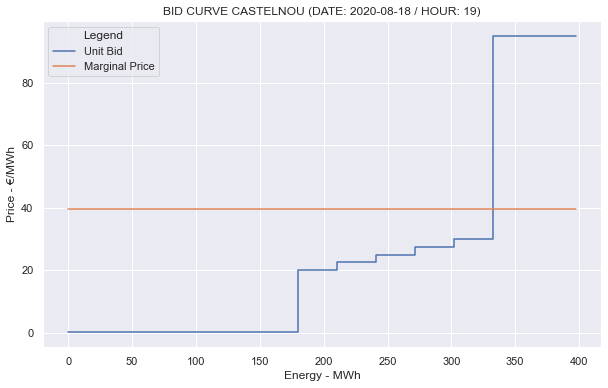

In [63]:
plot_bid_margprice(df_curve, '2020-08-18', 19, unit);

In this plot, it can be seen that the unit worked during this period, selling around 300 MWh at 40€/MWh aproximately, and that this unit was one of the ones that determined the marginal price for that period so, in theory, this plant did not take any surplus with this bid.

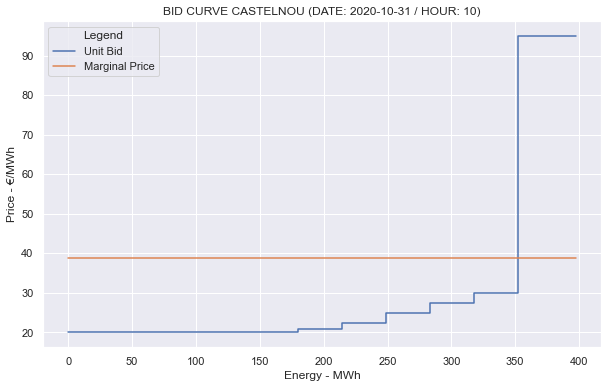

In [64]:
plot_bid_margprice(df_curve, '2020-10-31', 10, unit);

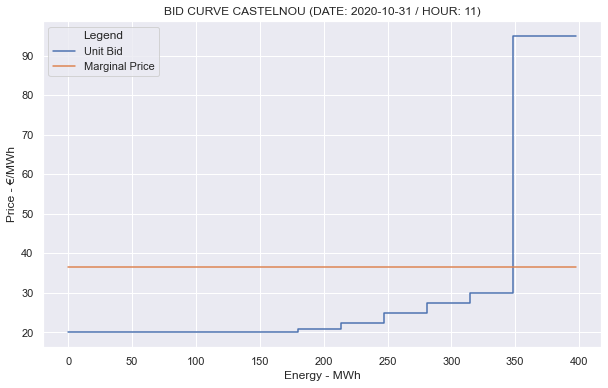

In [65]:
plot_bid_margprice(df_curve, '2020-10-31', 11, unit);

IndexError: single positional indexer is out-of-bounds

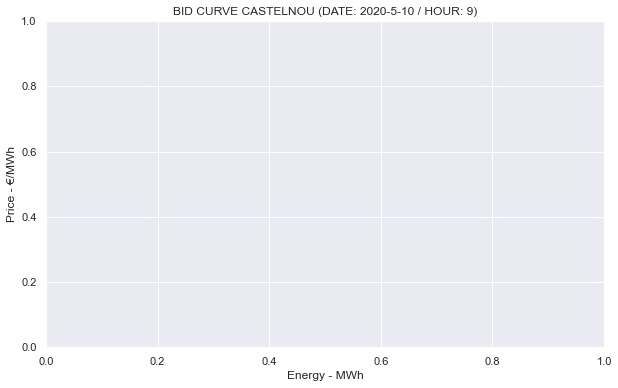

In [66]:
plot_bid_margprice(df_curve, '2020-5-10', 9, unit);

In this example, the unit worked at 190 MWh at 15 €/MWh. In this case, in theory the surplus of the unit is the difference between 15 €/MWh and aprox. 1 €/MWh (bid price).

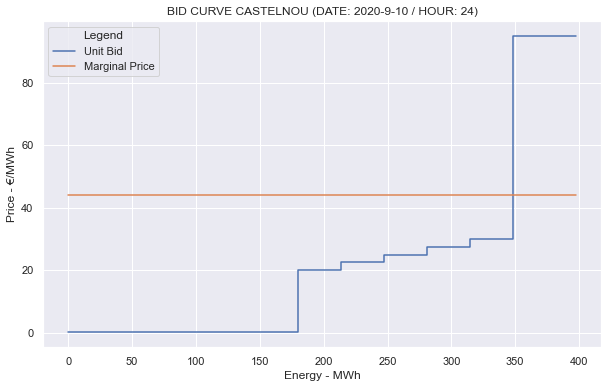

In [70]:
plot_bid_margprice(df_curve, '2020-9-10', 24, unit);

In the following plots, all the bids for a given date are plotted together with the marginal price for that date. This plot can be used to see if the unit worked during that date and which one was its revenue.

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()


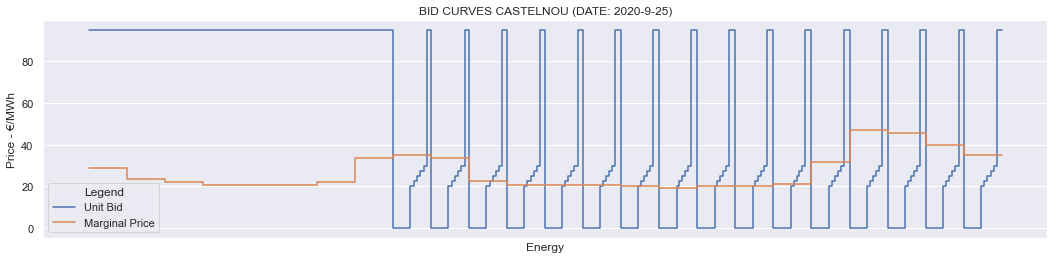

In [71]:
plot_bid_margprice_day(df_curve, '2020-9-25', unit);

During this date, it seems that the unit only worked from hour 20 to 24 or at very low load during the rest of the day (not cosidering the first hours of the day).

/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()
/home/dsc/Repos/TFM/TFM_PredCurve_Tools.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Energy_tot_date'] = df_plot['Energy'].cumsum()


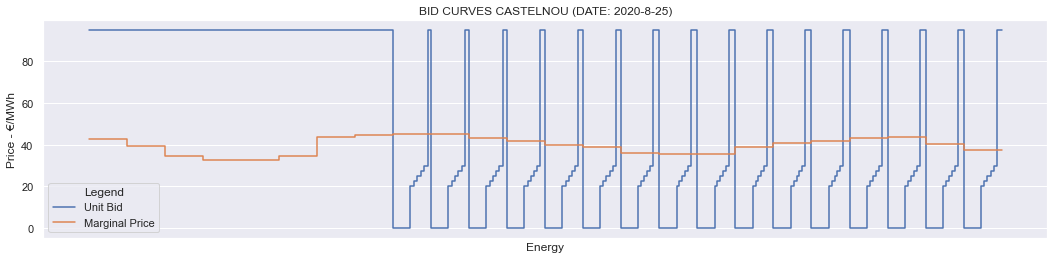

In [73]:
plot_bid_margprice_day(df_curve, '2020-8-25', unit)

In the next plot, it can be seen the whole bid for an specific date. This plot is useful to see how simiar are the bid curves shape in certain hours.

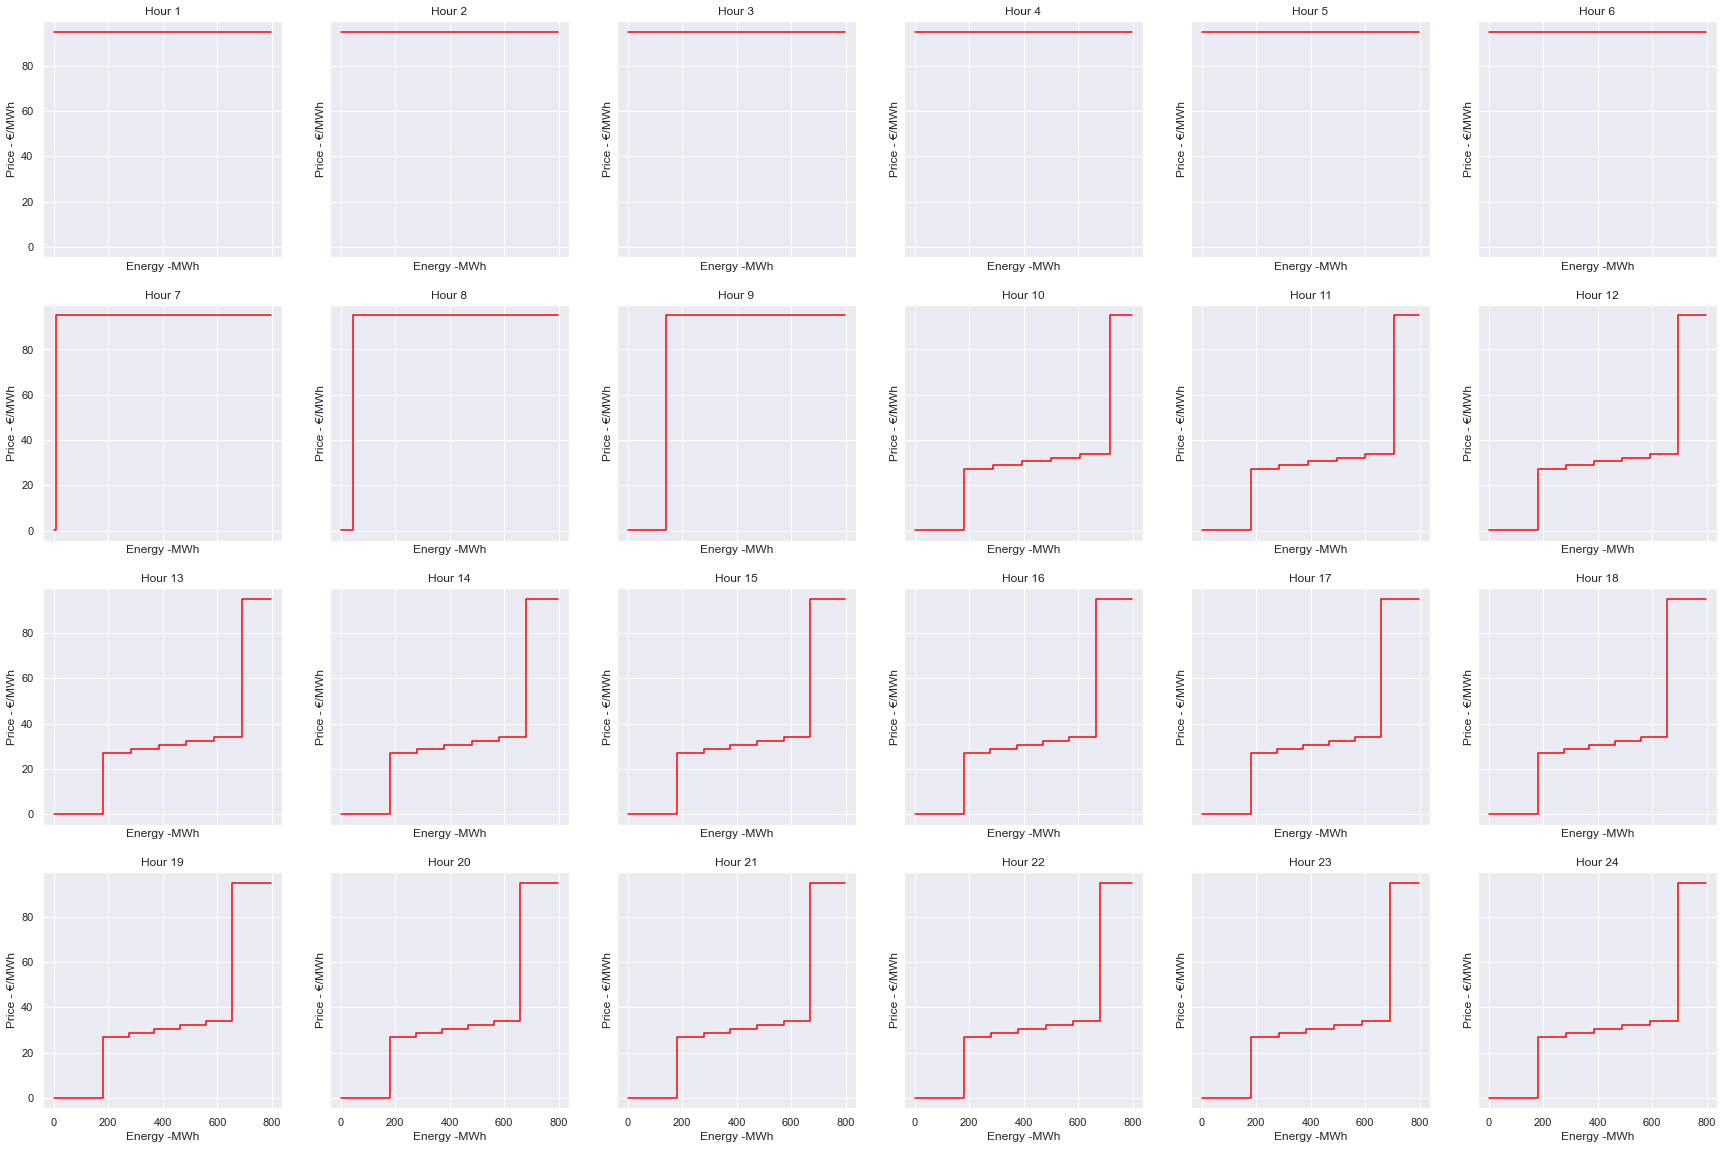

In [75]:
plot_24bids(df_curve, '2020-7-25')

In [76]:
df_curve.columns

Index(['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price', 'Energy',
       'Date', 'Weekday', 'Energy_tot', 'Marg_Price', 'NG_Price'],
      dtype='object')

#### CREATING A TIME-SERIES DATAFRAME (with date and hour as index)

In this section a time-series dataframe is created to plot properly the bids, and seeing the gaps in the bids (where units are not available).

In [77]:
df_plot = df_curve.copy()
df_plot = df_plot[['Year','Month', 'Day', 'Period', 'Block', 'Energy_tot', 'Price', 'Marg_Price', 'NG_Price']]
df_plot.rename(columns={"Period": "Hour"}, inplace = True)
df_plot['Date_Hour'] = pd.to_datetime(df_plot[['Year', 'Month', 'Day', 'Hour']])
df_plot_reduced = df_plot.set_index('Date_Hour') #New time index is created
df_plot_reduced = df_plot_reduced[['Block', 'Hour', 'Energy_tot', 'Price', 'Marg_Price', 'NG_Price']]

In the following trend, all bids (considering all blocks) for the whole time periodit are plotted, together with the marginal price achieved by the market and the natural gas price (in a secondary y-axis).

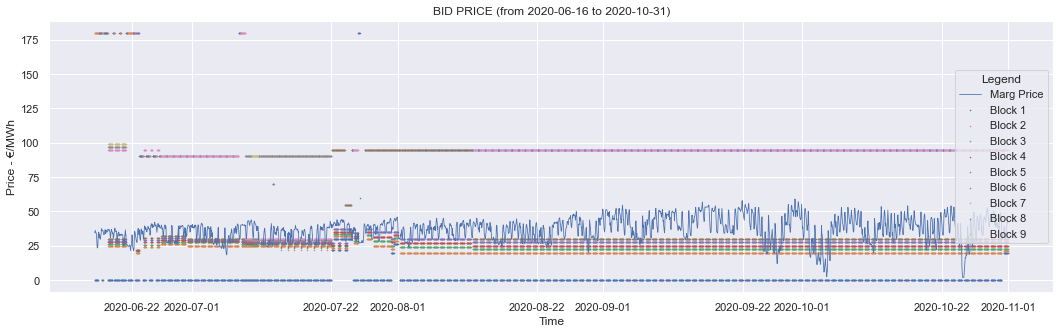

In [83]:
start_date = str(df_curve['Date'].min())[0:10]
end_date = str(df_curve['Date'].max())[0:10]

plot_bid_timeperiod(df_plot_reduced,start_date, end_date, 1, block_max, block_all)

Considering this plot, it seems that the unit bids do not have a clear relationship with natural gas price (as it should have in theory), but the relationship with marginal price are pretty clear though.

The following plot is just a graph considering only bids for two months.

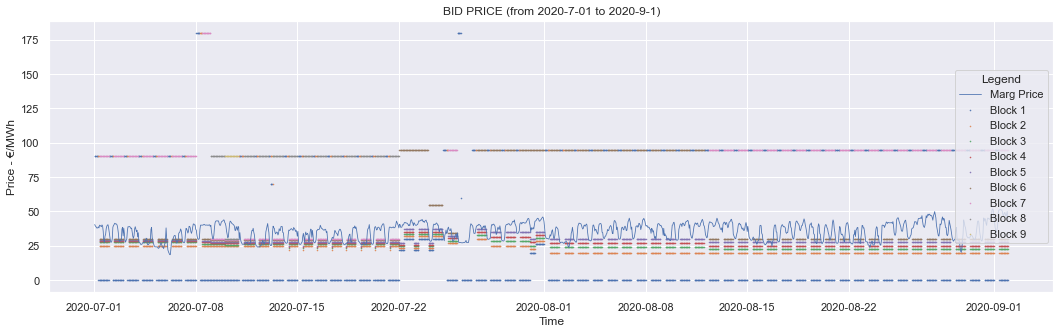

In [84]:
start_date = '2020-7-01'
end_date = '2020-9-1'

plot_bid_timeperiod(df_plot_reduced,start_date, end_date, 1, block_max, block_all)


Now, an example of January 2020 is shown.

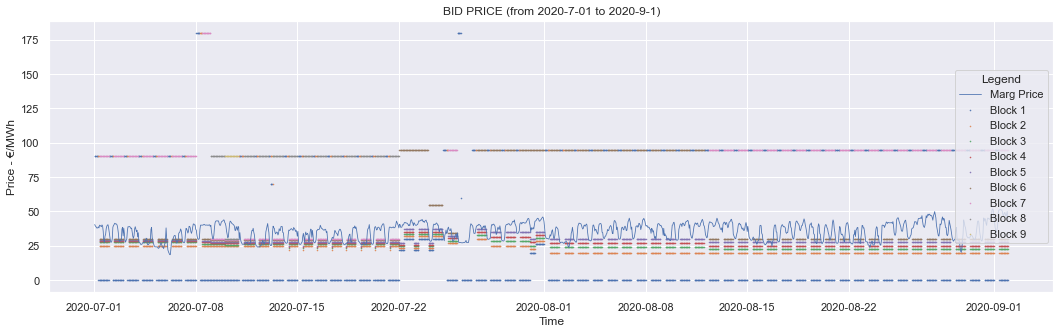

In [86]:
plot_bid_timeperiod(df_plot_reduced,'2020-7-01','2020-9-1',1,block_max, block_all)

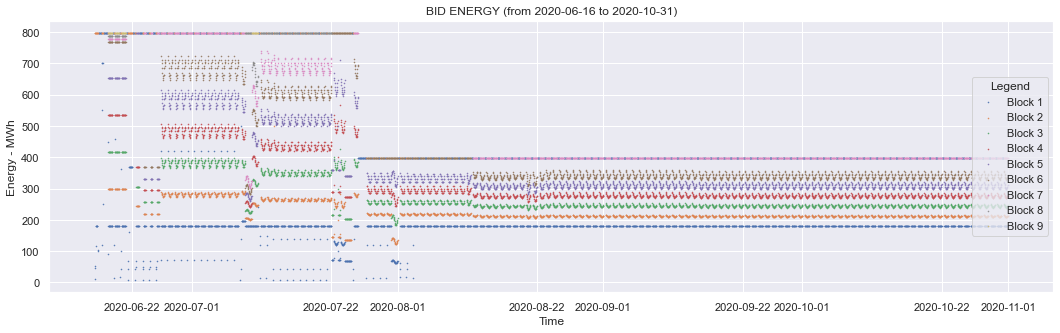

In [89]:
#Trend for the whole year period

plot_energy_timeperiod(df_plot_reduced,str(df_curve['Date'].min())[0:10],
                    str(df_curve['Date'].max())[0:10],1,block_max, block_all)

In the following plot, it can be seen the relationship between bid price and the hour of the bid for the whole year studied.

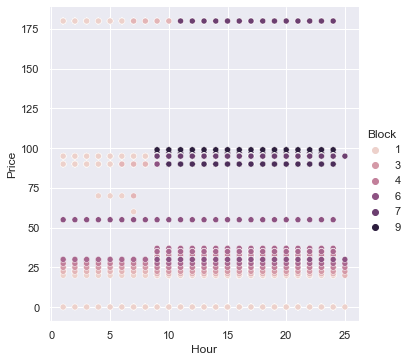

In [91]:
sns.relplot(data=df_plot_reduced, x='Hour', y='Price', hue='Block');

Same plot but considering the block energy for all the bids.

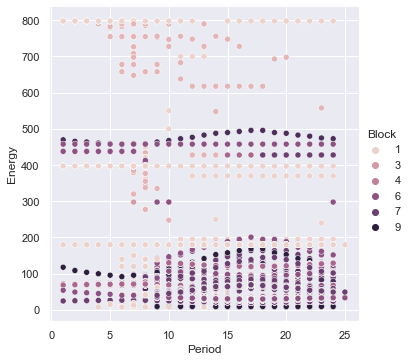

In [92]:
sns.relplot(data=df_curve, x='Period', y='Energy', hue='Block');

Same plot but considering the total energy for all the bids.

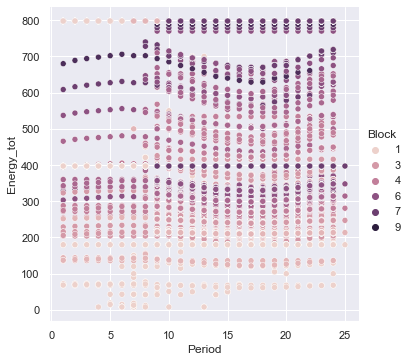

In [93]:
sns.relplot(data=df_curve, x='Period', y='Energy_tot', hue='Block');

In the following plot the number of bids splitted by block and hour is shown. It can be seen that block 12 is the most frequent and that during the first 7 hours of the day, bids are very simple with only one or two blocks.

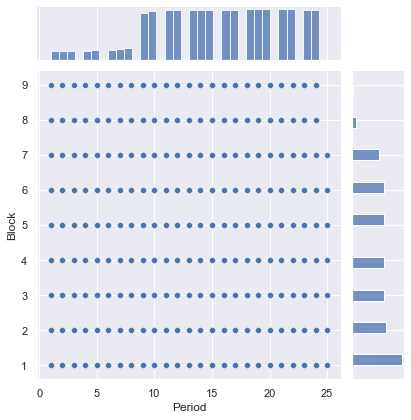

In [94]:
sns.jointplot(data=df_curve, x='Period', y='Block');

In the following plots, price and block energy distribution are shown.

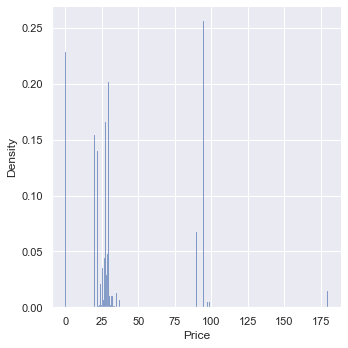

In [95]:
sns.displot(data=df_curve, x='Price',stat='density');

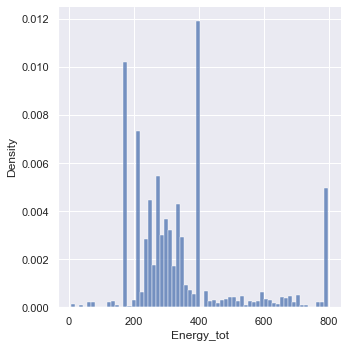

In [96]:
sns.displot(data=df_curve, x='Energy_tot',stat='density');

In the following plot, price and block relationship is presented. It can be seen how "real" bid prices (prices except block 1 and 12) vary around 30 €/MWh except for block 10 and 12 that this variation is higher.

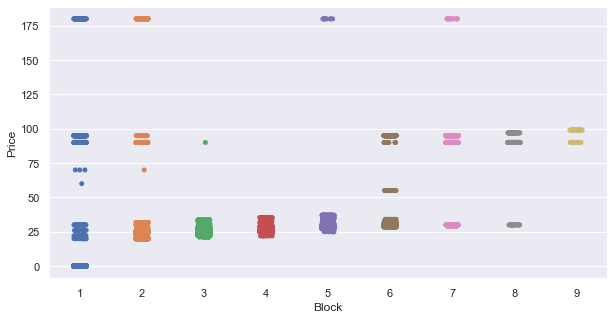

In [97]:
plt.figure().set_size_inches(10,5)  
sns.stripplot(data=df_curve, x='Block', y='Price');

In the following plot, price and weekday relationship is presented. It can be seen that bids do not seems to be very different depending on the weekday.

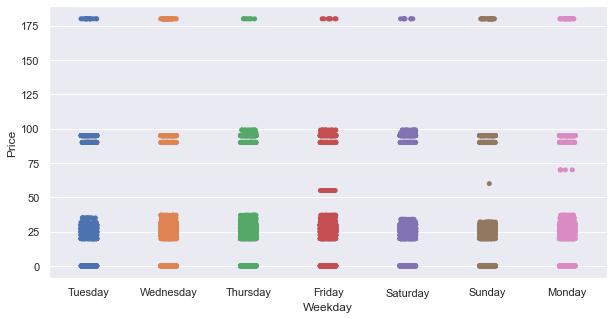

In [98]:
plt.figure().set_size_inches(10,5)
sns.stripplot(data=df_curve, x='Weekday', y='Price');

Plotting the relationship between weekday and total energy offered in the bids.

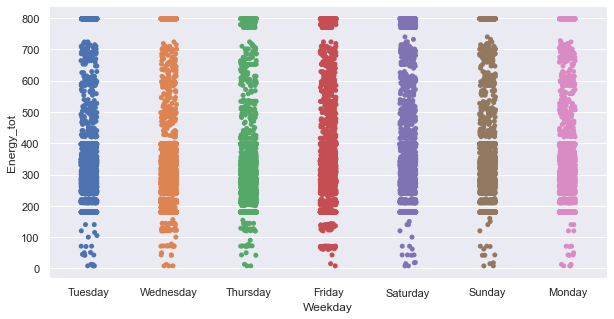

In [99]:
plt.figure().set_size_inches(10,5)
sns.stripplot(data=df_curve, x='Weekday', y='Energy_tot');

Plotting the relationship between hours and bid price.

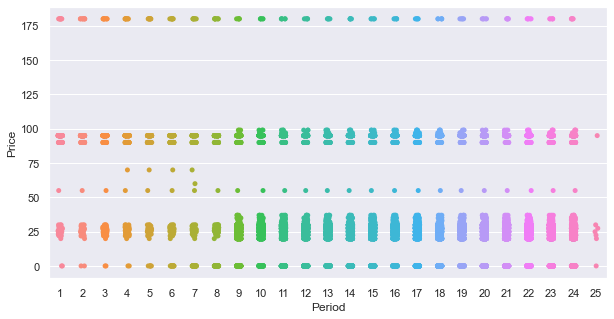

In [100]:
plt.figure().set_size_inches(10,5)
sns.stripplot(data=df_curve, x='Period', y='Price');

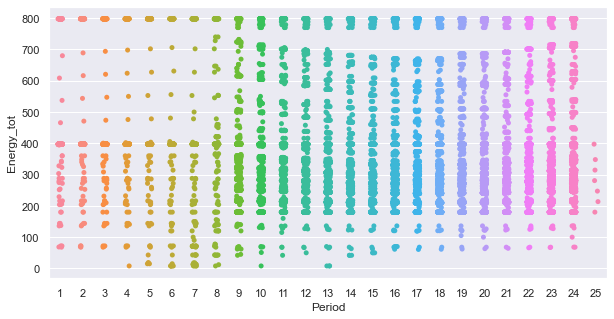

In [101]:
plt.figure().set_size_inches(10,5)
sns.stripplot(data=df_curve, x='Period', y='Energy_tot');

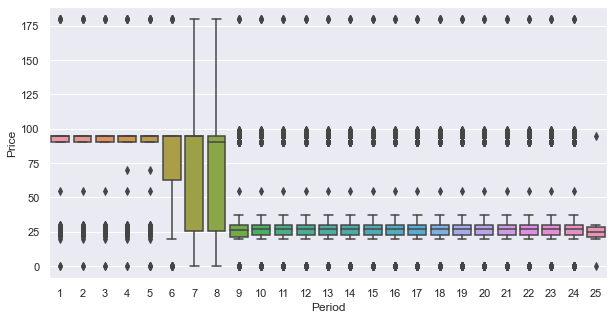

In [102]:
plt.figure().set_size_inches(10,5)
sns.boxplot(data=df_curve, x='Period', y='Price');

In the following box plots the relationship between bid blocks and bid price is presented.

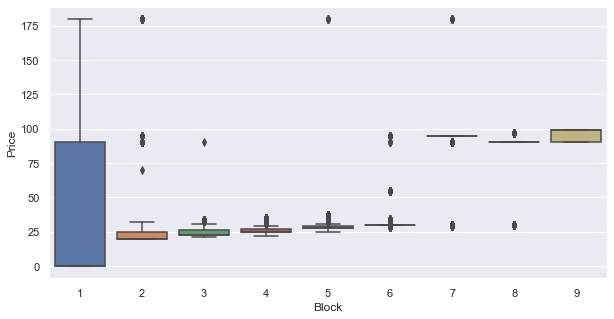

In [103]:
plt.figure().set_size_inches(10,5)
sns.boxplot(data=df_curve, x='Block', y='Price');

The same box-plots for block energy are presented below.

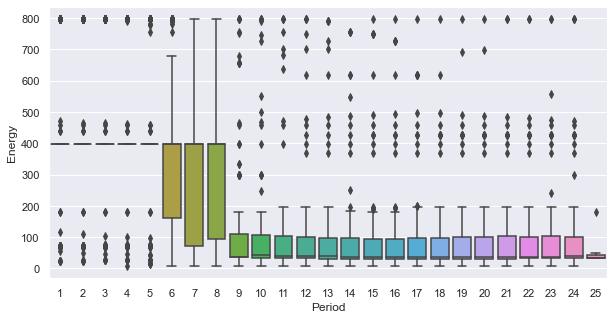

In [104]:
plt.figure().set_size_inches(10,5)
sns.boxplot(data=df_curve, x='Period', y='Energy');

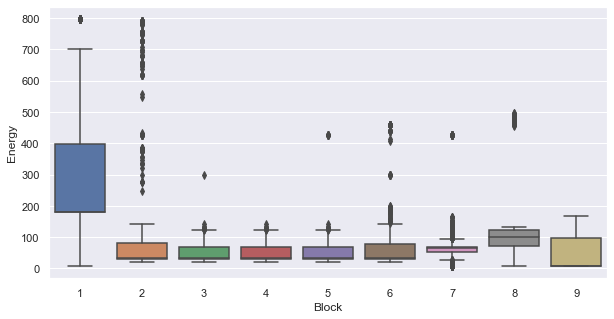

In [105]:
plt.figure().set_size_inches(10,5)
sns.boxplot(data=df_curve, x='Block', y='Energy');

The same box-plots for total bid energy are presented below.

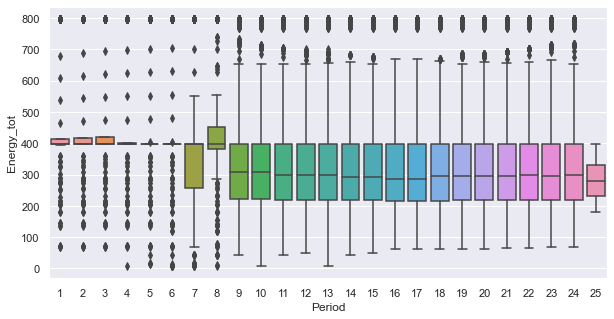

In [106]:
plt.figure().set_size_inches(10,5)
sns.boxplot(data=df_curve, x='Period', y='Energy_tot');

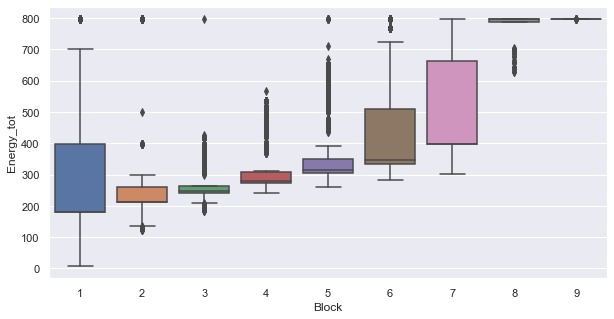

In [107]:
plt.figure().set_size_inches(10,5)
sns.boxplot(data=df_curve, x='Block', y='Energy_tot');

As a conclusion, bids seem to be very stable in price but not in block energy. 

Besides this, it is also remarkable that the relationship between natural gas price and bid price seems to be very weak.

## 3. DATA WRANGLING

In this section the raw data will be transformed to use as the input of the ML models that will be created in the next sections. The main data transformations will be the following:

* **Converting all days to a 24h days.** Considering the raw data from OMIE, there is one 23h day and one 25h day. Those days should be removed form the dataframe since they can be considered as outliers. The way to do it consists in adding a new hour in the case of 23h day (between hour 2 and 3), and dropping hour 3 in the case of 25h day.


* **Converting all bids into a full block bid.** That means that bids with less than the maximum number of blocks will be converted to a bid with the maximum number of blocks. The way to do it depends on the type of the bid (type A or B).


* **Creating a new dataframe considering all dates between the original time period selected.**


* **Creating a time lagged dataframe for Energy and Price features.**


* **Creating the dataframes that will be the input of the ML models** (set splitting, categorical encoding, normalization, etc.

### 3.1. CREATING A NEW DATAFRAME CONVERTING ALL DAYS INTO 24h-DAYS

In [108]:
#Checking that every day has 23, 24 or 25 hours
#We know that all periods have at least the block with the number equal to block_all

df_curve_hours = df_curve[(df_curve['Block']==block_all)].groupby('Date')['Period'].count()
df_curve_hours.value_counts()

24    136
25      1
17      1
Name: Period, dtype: int64

In [109]:
#Searching the days with 23h and 25h within the original data period. 
#It is known that in Spain times changes from 2am to 3am every last Sunday of March and 
#from 3am to 2am every last Sunday of October

days_25h, days_23h = days_25h_23h(df_curve)
days_25h, days_23h

([datetime.datetime(2020, 10, 25, 0, 0)], [])

In the following cells, the bids of the 23h and 25h days are shown.

In [110]:
#Bids for the 25h day for hours between 1 and 5, it can be seen that bid for hour 2 and 3 are equal.
df_curve[(df_curve['Date']==days_25h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
15502,797.80,2020,10,25,1,1,95.00,397.30,2020-10-25,Sunday,397.30,10.00,2.91
15503,797.80,2020,10,25,2,1,95.00,397.30,2020-10-25,Sunday,397.30,5.51,2.91
15504,797.80,2020,10,25,3,1,95.00,397.30,2020-10-25,Sunday,397.30,1.95,2.91
15505,797.80,2020,10,25,4,1,95.00,397.30,2020-10-25,Sunday,397.30,1.95,2.91
15506,797.80,2020,10,25,5,1,95.00,397.30,2020-10-25,Sunday,397.30,1.95,2.91


In [111]:
#Bids for the 23h day for hours between 1 and 5, it can be seen that bid for hour 2 and 3 are equal.
df_curve[(df_curve['Date']==days_23h[0])&(df_curve['Period'].isin([1,2,3,4,5]))]

IndexError: list index out of range

In [112]:
#New dataframe is created considering 24h for all days
df_curve_24h = df_curve.copy()

In [113]:
#Funtions needed for renaming periods in 23h-days and 25h-days.

def change_25h_to24h(x):
    if x >= 4:
        x -= 1
    return x

def change_23h_to24h(x):
    if x >= 2:
        x += 1
    return x

In [114]:
#Transforming 25h-day into 24h-day.

for date_25h in days_25h:
    #dataframe only with 25h-day data
    df_curve_day25h = df_curve_24h[df_curve_24h['Date']==date_25h]
    #Deleting period 3 from 25h-days.
    df_curve_day25h = df_curve_day25h.drop(df_curve_day25h.loc[df_curve_day25h['Period']==3].index)
    #Renaming periods from 4 to 25 to 3 to 24
    df_curve_day25h['Period'] = df_curve_day25h['Period'].apply(change_25h_to24h)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_25h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day25h])

In [115]:
#Transforming 23h-day into 24h-day.

for date_23h in days_23h:
    df_curve_day23h = df_curve_24h[df_curve_24h['Date']==date_23h]
    #Renaming periods from 2 to 23 to 3 to 24
    df_curve_day23h['Period'] = df_curve_day23h['Period'].apply(change_23h_to24h)
    #Copying period 1 as period 2 and renaming it
    df_curve_day23h_period1 = df_curve_day23h[(df_curve_day23h['Date']==date_23h)&(df_curve_day23h['Period']==1)]
    df_curve_day23h_period1['Period'] = df_curve_day23h_period1['Period'].apply(lambda x: x+1)
    df_curve_day23h = df_curve_day23h.append(df_curve_day23h_period1, ignore_index=True)
    df_curve_24h = df_curve_24h.drop(df_curve_24h[df_curve_24h['Date']==date_23h].index)
    df_curve_24h = pd.concat([df_curve_24h,df_curve_day23h])

In [116]:
df_curve_24h = df_curve_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)
df_curve_24h.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
0,797.80,2020,6,16,8,1,0.10,12.00,2020-06-16,Tuesday,12.00,34.38,nan
1,797.80,2020,6,16,8,2,180.00,785.80,2020-06-16,Tuesday,797.80,34.38,nan
2,797.80,2020,6,16,9,1,0.10,45.00,2020-06-16,Tuesday,45.00,35.21,nan
3,797.80,2020,6,16,9,2,180.00,752.80,2020-06-16,Tuesday,797.80,35.21,nan
4,797.80,2020,6,16,10,1,0.10,51.00,2020-06-16,Tuesday,51.00,36.21,nan


In [117]:
df_curve_24h.shape, df_curve.shape

((16342, 13), (16343, 13))


### 3.2. CREATING A NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR 

In this section a new dataframe will be created from the original one (with only 24h-days) by completing the information por every hour that does not have the maximum number of blocks. 

It is important to point out that the original dataframe does not have the maximum number of blocks per each hour (or period), since not always is necessary in the biding curve. In order to use the information in the ML models, it is important that every hour is divided in the maximum number of blocks. 

Besides this, as the original dataframe does not have all days and hours for a given period (the unit can be out of order for centain periods of time), it is decided to create a new dataframe equal to the original one (only for dates, hours and blocks) but with the maximum number of blocks per each hour.

The new dataframe is created considering a dataframe structure for block 1 and then copying this new dataframe, changing the number of the block and appending it to the original. The correct structure of the datafrane will be created by doing it the "maximum block number" times.

After doing it, this new dataframe will be merged with the original one so NaN will be created for all the columns without blocks in the original dataframe. This NaN will be filled depending on each case.

#### 3.2.1. CREATING AN EMPTY DATAFRAME WITH THE SAME STRUCTRUE AS THE ORIGINAL WITH 24h-DAYS AND ALL BLOCKS PER EACH HOUR

In [118]:
#Creating a new df with the same structure of the orinal one, without 23h and 25h-days. 
#First of all, it is choosen from the original df the information from the date, hours and block 1.
#Block number "block_all" is choosen as it is the only block that appears in all bids.

df_block_24h = df_curve_24h[['Year','Month','Day','Period','Block']][df_curve_24h['Block']==block_all].reset_index(drop=True)

#Changing the value of all Blocks to 1
df_block_24h['Block'] = 1

#Creating a new dataframe with the same structure for all Blocks
df_block_tot_24h = pd.DataFrame()

for block_24h in range(1,block_max+1):
    df_block_new_24h = df_block_24h.copy()
    df_block_new_24h['Block'] = block_24h
    df_block_tot_24h = pd.concat([df_block_tot_24h,df_block_new_24h])
    

df_block_tot_24h.reset_index(inplace=True,drop=True)

In [119]:
#Checking
len(df_block_tot_24h) == df_block_24h.shape[0]*block_max

True

In [120]:
df_block_tot_24h.shape

(29745, 5)

#### 3.2.2. CREATING AN NEW DATAFRAME WITH ALL BLOCKS PER EACH HOUR (without 23h and 25h-days)

In [121]:
#Now the complete dataframe is created by merging the original df (df_curve) with the new structure dataframe 
#created (df_block_tot)

df_tot_24h = df_curve_24h.merge(df_block_tot_24h,how='outer')

In [122]:
if block_max == block_all: # For Type A bids
    
   #New dataframe is sorted and reseted index
    df_tot_24h = df_tot_24h.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)

    #As the structrue dataframe has more rows that the original, a lot of NaN have been created.
    #These NaN must be filled.

    #As Block 12 is always in the original dataframe and dataframe is sorted by 'Block', bfill is the
    #right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
    df_tot_24h['Price'].fillna(method='bfill',inplace=True)

    #Pot_max is allways the same value
    df_tot_24h['Pot_max'].fillna(df_tot_24h['Pot_max'].max(),inplace=True)

    #For the same reason of Price, Weekday is filled with bfill method
    df_tot_24h['Weekday'].fillna(method='bfill',inplace=True)

    #For the same reason of Price, Datw is filled with bfill method
    df_tot_24h['Date'].fillna(method='bfill',inplace=True)

    #Energy NaN will be filled with 0 since allways Energy of Block 12 must be Pot_max (394.1)
    df_tot_24h['Energy'].fillna(float(0),inplace=True)

    #Now only Energy_tot columns have NaN
    #NaN in Energy_tot can be filled by interpolation method, but first of all a value must be included
    #in all cells with Block number equal to 1, since it is necessary 2 values in each Period to be able to 
    #interpolate and it is the only way to fill NaN in all Periods with only one Block (12)

    #Filling Energy_tot NaN for Block=1 with 50
    df_tot_24h['Energy_tot'][(df_tot_24h['Block']==1) & 
                         (df_tot_24h['Energy_tot'].isnull())] = df_tot_24h['Energy_tot'][df_tot_24h['Block']==1].min()

    #Now remaining NaN in Energy_tot are filled by interpolation 
    df_tot_24h['Energy_tot'].interpolate(inplace=True)

    #NaN in Marg_Price will be filled with bfill method 
    df_tot_24h['Marg_Price'].fillna(method='bfill',inplace=True)
    
    #NaN in NG_Price will be filled with bfill method 
    df_tot_24h['NG_Price'].fillna(method='bfill',inplace=True)
    
else: # For Type B bids
    #New dataframe is sorted and reseted index
    df_tot_24h = df_tot_24h.sort_values(['Year','Month','Day','Period','Block']).reset_index(drop=True)

    #As the structrue dataframe has more rows that the original, a lot of NaN have been created.
    #These NaN must be filled.

    #As Block 1 is always in the original dataframe and dataframe is sorted by 'Block', bfill is the
    #right method to fill NaN since the meaning of no Block in OMIE curve is a fixed Price.
    df_tot_24h['Price'].fillna(method='ffill',inplace=True)

    #Pot_max is allways the same value
    df_tot_24h['Pot_max'].fillna(df_tot_24h['Pot_max'].max(),inplace=True)

    #For the same reason of Price, Weekday is filled with bfill method
    df_tot_24h['Weekday'].fillna(method='ffill',inplace=True)

    #For the same reason of Price, Datw is filled with bfill method
    df_tot_24h['Date'].fillna(method='ffill',inplace=True)

    #Energy NaN will be filled with 0 since allways Energy of Block 1 must be Pot_max
    df_tot_24h['Energy'].fillna(float(0),inplace=True)

    #For the same reason of Price, Energy_tot is filled with bfill method
    df_tot_24h['Energy_tot'].fillna(method='ffill',inplace=True)

    #NaN in Marg_Price will be filled with bfill method 
    df_tot_24h['Marg_Price'].fillna(method='ffill',inplace=True)
    
    #NaN in NG_Price will be filled with bfill method 
    df_tot_24h['NG_Price'].fillna(method='bfill',inplace=True)

In [123]:
df_tot_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
0,797.80,2020,6,16,8,1,0.10,12.00,2020-06-16,Tuesday,12.00,34.38,1.55
1,797.80,2020,6,16,8,2,180.00,785.80,2020-06-16,Tuesday,797.80,34.38,1.55
2,797.80,2020,6,16,8,3,180.00,0.00,2020-06-16,Tuesday,797.80,34.38,1.55
3,797.80,2020,6,16,8,4,180.00,0.00,2020-06-16,Tuesday,797.80,34.38,1.55
4,797.80,2020,6,16,8,5,180.00,0.00,2020-06-16,Tuesday,797.80,34.38,1.55
5,797.80,2020,6,16,8,6,180.00,0.00,2020-06-16,Tuesday,797.80,34.38,1.55
6,797.80,2020,6,16,8,7,180.00,0.00,2020-06-16,Tuesday,797.80,34.38,1.55
7,797.80,2020,6,16,8,8,180.00,0.00,2020-06-16,Tuesday,797.80,34.38,1.55
8,797.80,2020,6,16,8,9,180.00,0.00,2020-06-16,Tuesday,797.80,34.38,1.55
9,797.80,2020,6,16,9,1,0.10,45.00,2020-06-16,Tuesday,45.00,35.21,1.55


In [124]:
#Checking NaN
df_tot_24h.isnull().values.any()

True

In [125]:
#Cheching that everything is OK between original dataframe and new one

df_curve[['Block','Energy_tot']] [df_curve['Block']==1].value_counts()

Block  Energy_tot
1      180.00        2055
       397.30         779
       797.80         227
       68.00           24
       8.00            16
                     ... 
       77.00            1
       70.80            1
       70.40            1
       69.60            1
       90.00            1
Length: 71, dtype: int64

In [126]:
df_tot_24h[['Block','Energy_tot']] [df_tot_24h['Block']==1].value_counts()

Block  Energy_tot
1      180.00        2055
       397.30         778
       797.80         227
       68.00           24
       8.00            16
                     ... 
       77.00            1
       70.80            1
       70.40            1
       69.60            1
       90.00            1
Length: 71, dtype: int64

It is OK since the only modification is 50 that goes from 75 to 1091

In [127]:
df_tot_24h.shape

(29745, 13)

### 3.3. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h and 25h-days)

In order to create a proper dataframe used in the models it is important to consider the data from previous bids, so a dataframe with the Energy and Price with a time lag of 24h and 168h is created. The best way to do it is to shift down Energy and Price columns 24 times the maximum block number, and 168 times the maximum block number. This only works if all the dates, hours, and blocks are in the the dataframe. As it cannot be the case, a new dataframe should be created with NaN in the places where the dates and hours are missing in the original dataframe.

#### 3.3.1. CREATING AN EMPTY DATA STRUCTURE GIVEN A STARTING AND ENDING DATES  (without 23h & 25h-days)

In [128]:
struct_block_24h = df_structure_24h(df_tot_24h['Date'].min().year,
                              df_tot_24h['Date'].min().month,
                              df_tot_24h['Date'].min().day,
                              df_tot_24h['Date'].max().year,
                              df_tot_24h['Date'].max().month,
                              df_tot_24h['Date'].max().day,
                              block_max) 

In [129]:
struct_block_24h

,Date,Year,Month,Day,Period,Block
0,2020-06-16,2020,6,16,1,1
1,2020-06-16,2020,6,16,1,2
2,2020-06-16,2020,6,16,1,3
3,2020-06-16,2020,6,16,1,4
4,2020-06-16,2020,6,16,1,5
...,...,...,...,...,...,...
29803,2020-10-31,2020,10,31,24,5
29804,2020-10-31,2020,10,31,24,6
29805,2020-10-31,2020,10,31,24,7
29806,2020-10-31,2020,10,31,24,8


#### 3.3.2. CREATING AN NEW DATAFRAME WITH ALL DATES, HOURS AND BLOCKS BETWEEN THE ORIGINAL TIME PERIOD (without 23h &25h-days)

In [130]:
df_tot_24h.shape, struct_block_24h.shape

((29745, 13), (29808, 6))

In [131]:
#Now the complete dataframe is created by merging the complete-block df (df_tot) with the new structure dataframe 
#created (structure_block)

df_tot_struct_24h = df_tot_24h.merge(struct_block_24h,how='outer')
df_tot_struct_24h = df_tot_struct_24h.sort_values(['Date','Period','Block']).reset_index(drop=True)

In [132]:
df_tot_struct_24h.head(15)

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
0,nan,2020,6,16,1,1,nan,nan,2020-06-16,NaN,nan,nan,nan
1,nan,2020,6,16,1,2,nan,nan,2020-06-16,NaN,nan,nan,nan
2,nan,2020,6,16,1,3,nan,nan,2020-06-16,NaN,nan,nan,nan
3,nan,2020,6,16,1,4,nan,nan,2020-06-16,NaN,nan,nan,nan
4,nan,2020,6,16,1,5,nan,nan,2020-06-16,NaN,nan,nan,nan
5,nan,2020,6,16,1,6,nan,nan,2020-06-16,NaN,nan,nan,nan
6,nan,2020,6,16,1,7,nan,nan,2020-06-16,NaN,nan,nan,nan
7,nan,2020,6,16,1,8,nan,nan,2020-06-16,NaN,nan,nan,nan
8,nan,2020,6,16,1,9,nan,nan,2020-06-16,NaN,nan,nan,nan
9,nan,2020,6,16,2,1,nan,nan,2020-06-16,NaN,nan,nan,nan


In [133]:
df_tot_24h.shape, struct_block_24h.shape, df_tot_struct_24h.shape

((29745, 13), (29808, 6), (29808, 13))

This new dataframe has NaN since there are days without data in the original data. These NaN will be dropped in later stages where the time-lagged dataframe is created.

In [134]:
#Checking NaN where there are missing data in the raw information
df_tot_struct_24h[df_tot_struct_24h['Date']=='2019-11-6']

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price


### PLOTING WITH NEW df_tot_struct_24h

In [135]:
df_tot_struct_24h[df_tot_struct_24h['Block']==1]

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price
0,nan,2020,6,16,1,1,nan,nan,2020-06-16,NaN,nan,nan,nan
9,nan,2020,6,16,2,1,nan,nan,2020-06-16,NaN,nan,nan,nan
18,nan,2020,6,16,3,1,nan,nan,2020-06-16,NaN,nan,nan,nan
27,nan,2020,6,16,4,1,nan,nan,2020-06-16,NaN,nan,nan,nan
36,nan,2020,6,16,5,1,nan,nan,2020-06-16,NaN,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29763,797.80,2020,10,31,20,1,20.00,180.00,2020-10-31,Saturday,180.00,41.45,3.03
29772,797.80,2020,10,31,21,1,20.00,180.00,2020-10-31,Saturday,180.00,44.83,3.03
29781,797.80,2020,10,31,22,1,20.00,180.00,2020-10-31,Saturday,180.00,44.82,3.03
29790,797.80,2020,10,31,23,1,20.00,180.00,2020-10-31,Saturday,180.00,40.90,3.03


In [136]:
#Creating a Time-series dataframe (with date and hour as index)
df_plot_24h = df_tot_struct_24h.copy()
df_plot_24h = df_plot_24h[['Year','Month', 'Day', 'Period', 'Block', 'Energy_tot', 'Price', 
                           'Marg_Price', 'NG_Price']]
df_plot_24h.rename(columns={"Period": "Hour"}, inplace = True)
df_plot_24h['Date_Hour'] = pd.to_datetime(df_plot_24h[['Year', 'Month', 'Day', 'Hour']])
df_plot_24h_reduced = df_plot_24h.set_index('Date_Hour')
df_plot_24h_reduced = df_plot_24h_reduced[['Block', 'Hour', 'Energy_tot', 'Price', 'Marg_Price', 'NG_Price']]

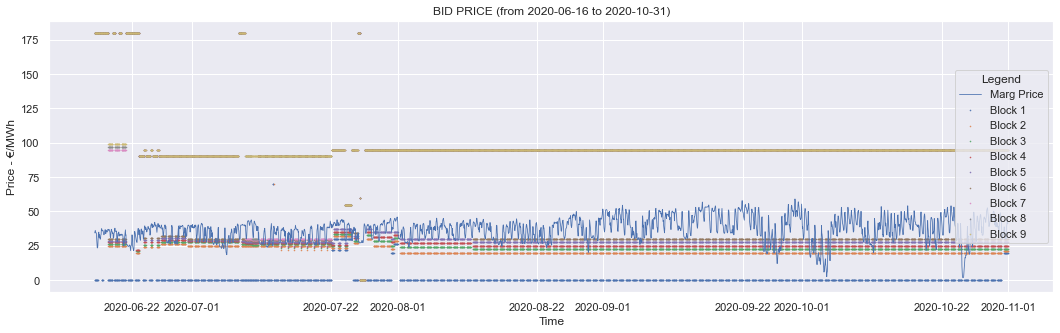

In [137]:
plot_bid_timeperiod(df_plot_24h_reduced,str(df_tot_struct_24h['Date'].min())[0:10],
                    str(df_tot_struct_24h['Date'].max())[0:10],1,block_max, block_all)

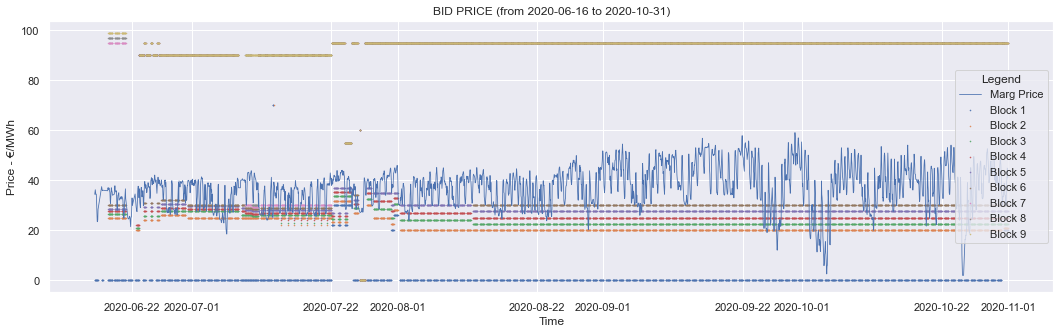

In [140]:
#Plotting without block 1 and maximum
plot_bid_timeperiod(df_plot_24h_reduced[(df_plot_24h_reduced['Price']!=df_plot_24h_reduced['Price'].max())],
                    str(df_tot_struct_24h['Date'].min())[0:10],
                    str(df_tot_struct_24h['Date'].max())[0:10],
                    1,block_max, 1)

### 3.4. CREATING AN NEW DATAFRAME WITH PRICE AND ENERGY TIME-LAGGED

In [142]:
df_tot_lagT = df_tot_struct_24h.copy()

In [143]:
df_tot_lagT.shape

(29808, 13)

In [144]:
time_lag1 = 24 #One day in hours
time_lag2 = 24*7 #One week in hours
num_blocks = block_max #Number of blocks per each hour

df_tot_lagT['Energy_24h'] = df_tot_lagT['Energy'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_168h'] = df_tot_lagT['Energy'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Price_24h'] = df_tot_lagT['Price'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Price_168h'] = df_tot_lagT['Price'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Energy_tot_24h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Energy_tot_168h'] = df_tot_lagT['Energy_tot'].shift(periods=time_lag2*num_blocks)

df_tot_lagT['Marg_Price_24h'] = df_tot_lagT['Marg_Price'].shift(periods=time_lag1*num_blocks)

#Just for checking purposes
df_tot_lagT['Date_24h'] = df_tot_lagT['Date'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Period_24h'] = df_tot_lagT['Period'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Block_24h'] = df_tot_lagT['Block'].shift(periods=time_lag1*num_blocks)
df_tot_lagT['Date_168h'] = df_tot_lagT['Date'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Period_168h'] = df_tot_lagT['Period'].shift(periods=time_lag2*num_blocks)
df_tot_lagT['Block_168h'] = df_tot_lagT['Block'].shift(periods=time_lag2*num_blocks)

In [145]:
df_tot_lagT.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Marg_Price,NG_Price,Energy_24h,Energy_168h,Price_24h,Price_168h,Energy_tot_24h,Energy_tot_168h,Marg_Price_24h,Date_24h,Period_24h,Block_24h,Date_168h,Period_168h,Block_168h
0,nan,2020,6,16,1,1,nan,nan,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
1,nan,2020,6,16,1,2,nan,nan,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
2,nan,2020,6,16,1,3,nan,nan,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
3,nan,2020,6,16,1,4,nan,nan,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan
4,nan,2020,6,16,1,5,nan,nan,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaT,nan,nan,NaT,nan,nan


In [146]:
#Checking that the shift operation has been done OK

df_tot_lagT_checking = df_tot_lagT.copy()

df_tot_lagT_checking['Date_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_24h']
df_tot_lagT_checking['Date_168h_OK'] = df_tot_lagT_checking['Date'] - df_tot_lagT_checking['Date_168h']
df_tot_lagT_checking['Period_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_24h']
df_tot_lagT_checking['Period_168h_OK'] = df_tot_lagT_checking['Period'] - df_tot_lagT_checking['Period_168h']
df_tot_lagT_checking['Block_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_24h']
df_tot_lagT_checking['Block_168h_OK'] = df_tot_lagT_checking['Block'] - df_tot_lagT_checking['Block_168h']

In [147]:
df_tot_lagT_checking[['Date_OK','Date_168h_OK','Period_OK','Period_168h_OK','Block_OK','Block_168h_OK']].describe()

,Date_OK,Date_168h_OK,Period_OK,Period_168h_OK,Block_OK,Block_168h_OK
count,29592,28296,"29,592.00","28,296.00","29,592.00","28,296.00"
mean,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
std,0 days 00:00:00,0 days 00:00:00,0.00,0.00,0.00,0.00
min,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
25%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
50%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
75%,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00
max,1 days 00:00:00,7 days 00:00:00,0.00,0.00,0.00,0.00


Everthing is OK since date date time interval is 1 day and 7 days and period, and blocks are the same for all of the rows.

In [148]:
df_tot_lagT.columns

Index(['Pot_max', 'Year', 'Month', 'Day', 'Period', 'Block', 'Price', 'Energy',
       'Date', 'Weekday', 'Energy_tot', 'Marg_Price', 'NG_Price', 'Energy_24h',
       'Energy_168h', 'Price_24h', 'Price_168h', 'Energy_tot_24h',
       'Energy_tot_168h', 'Marg_Price_24h', 'Date_24h', 'Period_24h',
       'Block_24h', 'Date_168h', 'Period_168h', 'Block_168h'],
      dtype='object')

In [149]:
#Picking the correct columns
columns = ['Year', 'Month', 'Day', 'Period', 'Block', 'Date', 'Weekday',
           'Energy', 'Energy_tot','Price', 'Energy_24h', 'Energy_tot_24h', 'Price_24h', 
           'Energy_168h', 'Energy_tot_168h', 'Price_168h', 'Marg_Price', 'Marg_Price_24h','Pot_max', 'NG_Price']

In [150]:
df_tot_lagT = df_tot_lagT[columns]

In [151]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max,NG_Price
0,2020,6,16,1,1,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2020,6,16,1,2,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2020,6,16,1,3,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2020,6,16,1,4,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2020,6,16,1,5,2020-06-16,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [152]:
df_tot_lagT.shape

(29808, 20)

In [153]:
#Dropping all rows with NaN, since there are not enought data to build a dataframe (due to time lagging and 
#lack of data from the original dataframe

df_tot_lagT.dropna(inplace=True)
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max,NG_Price
1575,2020,6,23,8,1,2020-06-23,Tuesday,797.80,797.80,90.00,797.80,797.80,180.00,12.00,12.00,0.10,37.15,35.41,797.80,1.61
1576,2020,6,23,8,2,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,785.80,797.80,180.00,37.15,35.41,797.80,1.61
1577,2020,6,23,8,3,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
1578,2020,6,23,8,4,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
1579,2020,6,23,8,5,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61


In [154]:
df_tot_lagT = df_tot_lagT.sort_values(['Year', 'Month', 'Day', 'Period', 'Block'])
df_tot_lagT

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max,NG_Price
1575,2020,6,23,8,1,2020-06-23,Tuesday,797.80,797.80,90.00,797.80,797.80,180.00,12.00,12.00,0.10,37.15,35.41,797.80,1.61
1576,2020,6,23,8,2,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,785.80,797.80,180.00,37.15,35.41,797.80,1.61
1577,2020,6,23,8,3,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
1578,2020,6,23,8,4,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
1579,2020,6,23,8,5,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29801,2020,10,31,24,3,2020-10-31,Saturday,33.60,247.20,22.50,33.60,247.20,22.50,33.60,247.20,22.50,39.75,42.41,797.80,3.03
29802,2020,10,31,24,4,2020-10-31,Saturday,33.60,280.80,25.00,33.60,280.80,25.00,33.60,280.80,25.00,39.75,42.41,797.80,3.03
29803,2020,10,31,24,5,2020-10-31,Saturday,33.60,314.40,27.50,33.60,314.40,27.50,33.60,314.40,27.50,39.75,42.41,797.80,3.03
29804,2020,10,31,24,6,2020-10-31,Saturday,33.60,348.00,30.00,33.60,348.00,30.00,33.60,348.00,30.00,39.75,42.41,797.80,3.03


In [155]:
df_tot_lagT.reset_index(drop=True, inplace=True)
df_tot_lagT

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max,NG_Price
0,2020,6,23,8,1,2020-06-23,Tuesday,797.80,797.80,90.00,797.80,797.80,180.00,12.00,12.00,0.10,37.15,35.41,797.80,1.61
1,2020,6,23,8,2,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,785.80,797.80,180.00,37.15,35.41,797.80,1.61
2,2020,6,23,8,3,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
3,2020,6,23,8,4,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
4,2020,6,23,8,5,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28226,2020,10,31,24,3,2020-10-31,Saturday,33.60,247.20,22.50,33.60,247.20,22.50,33.60,247.20,22.50,39.75,42.41,797.80,3.03
28227,2020,10,31,24,4,2020-10-31,Saturday,33.60,280.80,25.00,33.60,280.80,25.00,33.60,280.80,25.00,39.75,42.41,797.80,3.03
28228,2020,10,31,24,5,2020-10-31,Saturday,33.60,314.40,27.50,33.60,314.40,27.50,33.60,314.40,27.50,39.75,42.41,797.80,3.03
28229,2020,10,31,24,6,2020-10-31,Saturday,33.60,348.00,30.00,33.60,348.00,30.00,33.60,348.00,30.00,39.75,42.41,797.80,3.03


In [156]:
#Searching for NaN

if df_tot_lagT.shape[0] == df_tot_lagT.dropna().shape[0]:
    print('No NaN in df')

No NaN in df


In [157]:
df_tot_lagT.head()

,Year,Month,Day,Period,Block,Date,Weekday,Energy,Energy_tot,Price,Energy_24h,Energy_tot_24h,Price_24h,Energy_168h,Energy_tot_168h,Price_168h,Marg_Price,Marg_Price_24h,Pot_max,NG_Price
0,2020,6,23,8,1,2020-06-23,Tuesday,797.80,797.80,90.00,797.80,797.80,180.00,12.00,12.00,0.10,37.15,35.41,797.80,1.61
1,2020,6,23,8,2,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,785.80,797.80,180.00,37.15,35.41,797.80,1.61
2,2020,6,23,8,3,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
3,2020,6,23,8,4,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61
4,2020,6,23,8,5,2020-06-23,Tuesday,0.00,797.80,90.00,0.00,797.80,180.00,0.00,797.80,180.00,37.15,35.41,797.80,1.61


### 3.5. CREATING DATAFRAMES AS MODELS' INPUT


### 3.5.1. BUILDING DATAFRAMES PER PERIOD (HOUR) - BLOCK ENERGY APPROACH

In this section models' input dataframes will be created, considering that differnt models will be built for every period (hour). 

First of all, the following features will be considered for X:

* Weekday
* Block
* Energy 24h lagged
* Energy 168h lagged
* Price 24h lagged
* Price 168h lagged
* Marginal Price 24h lagged

The target variables (y) will be:

* Energy
* Price

Note that block energy has been chosen Energy feature for models iput.

Dataframes will be splitted in the following way:

* TRAIN SET: data set to train the models
* VALIDATION SET: data set to validate and to select the models' hyperparamenters
* TEST SET: data set to test the models

The sppliting will be done considering the following time preriods:

* TEST SET: last month of the data set
* VALIDATION SET: month before TEST SET
* TRAIN SET: rest of the dataframe

In [158]:
df_set_dE = df_tot_lagT[['Year','Month','Day','Period','Date','Weekday','Block', 'Energy','Price',
                      'Energy_24h','Energy_168h','Price_24h','Price_168h', 'Marg_Price_24h']]

#### TEST SET

In [159]:
#Taking the last month of the current time period
df_set_dE_TEST = df_set_dE[(df_set_dE['Year'] == df_set_dE['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE['Date'].max().month)]

df_set_dE_TEST = df_set_dE_TEST.reset_index(drop=True)

#Splitting the TEST SET into 24 sets (one per hour)
df_set_dE_TEST_period = [df_set_dE_TEST[df_set_dE_TEST['Period']==hour] for hour in range(1,25)]

#Splitting the 24 TEST SETS into X and y (features and target)
df_X_dE_TEST = []
y_dE_TEST = []

for df in df_set_dE_TEST_period:
    df_X_dE_TEST.append(df[['Weekday','Block','Energy_24h','Energy_168h',
                            'Price_24h','Price_168h', 'Marg_Price_24h']])
    y_dE_TEST.append(np.array(df[['Energy','Price']]))

#### VALIDATION SET

In [160]:
#This original code works only if there is no gap between the last day of the VALIDATION month and the 
#firs day of the TEST month.
#df_set_dE_VAL = df_set_dE[(df_set_dE['Year'] == (df_set_dE_TEST['Date'].min() - timedelta(days=1)).year)&
#               (df_set_dE['Month'] == (df_set_dE_TEST['Date'].min() - timedelta(days=1)).month)]
#In order to avoid this problem, it is better the following code:

df_set_dE_VAL = df_set_dE[(df_set_dE['Year'] == df_set_dE_TEST['Date'].max().year)&
               (df_set_dE['Month'] == df_set_dE_TEST['Date'].max().month-1)]

df_set_dE_VAL = df_set_dE_VAL.reset_index(drop=True)

#Splitting the VALIDATION SET into 24 sets (one per hour)
df_set_dE_VAL_period = [df_set_dE_VAL[df_set_dE_VAL['Period']==hour] for hour in range(1,25)]

#Splitting the 24 TEST SETS into X and y (features and target)
df_X_dE_VAL = []
y_dE_VAL = []

for df in df_set_dE_VAL_period:
    df_X_dE_VAL.append(df[['Weekday','Block','Energy_24h','Energy_168h',
                           'Price_24h','Price_168h','Marg_Price_24h']])
    y_dE_VAL.append(np.array(df[['Energy','Price']]))

#### TRAIN SET

In [161]:
#Taking the rest of the dataframe as the TRAIN SET.
Period_min = df_set_dE[df_set_dE['Date'] == df_set_dE['Date'].min()]['Period'].min()
Period_VAL_min = df_set_dE_VAL[df_set_dE_VAL['Date'] == df_set_dE_VAL['Date'].min()]['Period'].min()

df_set_dE_TRAIN_start = df_set_dE[((df_set_dE['Date'] == df_set_dE['Date'].min()) 
                                   & (df_set_dE['Period'] == Period_min)  
                                   & (df_set_dE['Block'] == 1))].index

df_set_dE_TRAIN_end = df_set_dE[(df_set_dE['Date'] == df_set_dE_VAL['Date'].min()) 
                                & (df_set_dE['Period'] == Period_VAL_min)  
                                & (df_set_dE['Block'] == 1)].index -1

df_set_dE_TRAIN = df_set_dE.iloc[df_set_dE_TRAIN_start[0]:df_set_dE_TRAIN_end[0]+1]

#Splitting the TRAIN SET into 24 sets (one per hour)
df_set_dE_TRAIN_period = [df_set_dE_TRAIN[df_set_dE_TRAIN['Period']==hour] for hour in range(1,25)]

df_X_dE_TRAIN = []
y_dE_TRAIN = []

#Splitting the 24 TRAIN SETS into X and y (features and target)
for df in df_set_dE_TRAIN_period:
    df_X_dE_TRAIN.append(df[['Weekday','Block','Energy_24h','Energy_168h',
                             'Price_24h','Price_168h','Marg_Price_24h']])
    y_dE_TRAIN.append(np.array(df[['Energy','Price']]))

#### SPLIT CHECKS

In [162]:
split_dates = pd.DataFrame({'START DATE':[datetime.strftime(df_set_dE_TRAIN['Date'].min(), '%Y-%m-%d'),
                                           datetime.strftime(df_set_dE_VAL['Date'].min(), '%Y-%m-%d'),
                                           datetime.strftime(df_set_dE_TEST['Date'].min(), '%Y-%m-%d')],
                              'END DATE':[datetime.strftime(df_set_dE_TRAIN['Date'].max(), '%Y-%m-%d'),
                                          datetime.strftime(df_set_dE_VAL['Date'].max(), '%Y-%m-%d'),
                                          datetime.strftime(df_set_dE_TEST['Date'].max(), '%Y-%m-%d')]},
                              index =['TRAIN_SET', 'VALIDATION SET', 'TEST SET'])
split_dates

,START DATE,END DATE
TRAIN_SET,2020-06-23,2020-08-31
VALIDATION SET,2020-09-01,2020-09-30
TEST SET,2020-10-01,2020-10-31


In [163]:
if (df_set_dE.shape[0] == df_set_dE_TRAIN.shape[0]+df_set_dE_VAL.shape[0]+df_set_dE_TEST.shape[0]):
    print('SPLIT SET OK')
else:
    print('SPLIT SET ERROR')

SPLIT SET OK


#### TRAIN + VALIDATION SET

TRAIN + VALIDATION SET will be used for ML models without hyperparameters.

In [164]:
#Splitting the 24 TRAIN SETS into X (features)
df_X_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    df_X_dE_TRAIN_VAL.append(pd.concat([df_X_dE_TRAIN[hour], df_X_dE_VAL[hour]],axis=0))

In [165]:
#Splitting the 24 TRAIN SETS into y (targets)
y_dE_TRAIN_VAL = []

for hour in range(0,len(df_X_dE_TRAIN)):
    y_dE_TRAIN_VAL.append(np.concatenate((y_dE_TRAIN[hour], 
                             y_dE_VAL[hour]),
                            axis=0))

### 3.5.2. NORMALIZATION AND ONE-HOT-ENCODING FOR FEATURES MODELS' INPUT - DELTA ENERGY APPROACH

In this section X_train, X_val, and X_test will be transformed to normalize the Price and Energy features (24h and 168h lagged) and Weekday, and Block (categorical variables) will be transformed using One-Hot-Encoding.

#### TRAIN SET - ENCODING

In [166]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder

df_X_TRAIN_cat = []

for df in df_X_dE_TRAIN:
    df_X_TRAIN_cat.append(df[['Weekday','Block']])

one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_TRAIN_cat_onehot_encoder = []
for hour in range(0,len(df_X_dE_TRAIN)):
    df_X_TRAIN_cat_onehot_encoder.append(one_encoder.fit(df_X_TRAIN_cat[hour]))
    
df_X_TRAIN_cat_onehot = []

for hour in range(0,len(df_X_dE_TRAIN)):
    
    df_X_TRAIN_cat_onehot.append(df_X_TRAIN_cat_onehot_encoder[hour].transform(df_X_TRAIN_cat[hour]))

In [167]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.

Energy_tot_max = df_tot_lagT['Pot_max'].max()

df_X_dE_TRAIN_energy_norm = []

for df in df_X_dE_TRAIN:
    df_X_dE_TRAIN_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)

In [168]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

df_X_TRAIN_price = []
for df in df_X_dE_TRAIN:
    df_X_TRAIN_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])


std_encoder = StandardScaler()

#Fitting with TRAIN TEST
df_X_TRAIN_price_std_encoder = []
for hour in range(0,len(df_X_dE_TRAIN)):
    df_X_TRAIN_price_std_encoder.append(std_encoder.fit(df_X_TRAIN_price[hour]))
    
#Transforming with TRAIN TEST
df_X_TRAIN_price_std = []
for hour in range(0,len(df_X_dE_TRAIN)):
    df_X_TRAIN_price_std.append(df_X_TRAIN_price_std_encoder[hour].transform(df_X_TRAIN_price[hour]))

In [169]:
#Creating X fro TRAIN SET

X_dE_TRAIN = []
for hour in range(0,len(df_X_dE_TRAIN)):
    X_dE_TRAIN.append(np.concatenate((df_X_TRAIN_cat_onehot[hour], 
                             df_X_dE_TRAIN_energy_norm[hour],
                             df_X_TRAIN_price_std[hour]),
                            axis=1))

In [170]:
#Checks
df_X_TRAIN_cat_onehot[0].shape, df_X_dE_TRAIN_energy_norm[0].shape, df_X_TRAIN_price_std[0].shape

((621, 16), (621, 2), (621, 3))

In [171]:
#Checks
len(df_X_TRAIN_cat_onehot), len(df_X_dE_TRAIN_energy_norm), len(df_X_TRAIN_price_std)

(24, 24, 24)

In [172]:
#Checks
len(df_X_dE_TRAIN)

24

In [173]:
#Checks
X_dE_TRAIN[0].shape

(621, 21)

In [174]:
type(X_dE_TRAIN[0])

numpy.ndarray

#### VALIDATION SET - ENCODING --> FITTING WITH TRAIN SET

In [175]:
#One-hot encoding will be used to convert variables from categorical to binary.

df_X_VAL_cat = []
for df in df_X_dE_VAL:
    df_X_VAL_cat.append(df[['Weekday','Block']])
    
#Transforming with TRAIN TEST
df_X_VAL_cat_onehot = []
for hour in range(0,len(df_X_dE_VAL)):
    df_X_VAL_cat_onehot.append(df_X_TRAIN_cat_onehot_encoder[hour].transform(df_X_VAL_cat[hour]))
    
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_VAL_energy_norm = []
for df in df_X_dE_VAL:
    df_X_dE_VAL_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)
df_X_VAL_price = []

for df in df_X_dE_VAL:
    df_X_VAL_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])

#Transforming with TRAIN TEST
df_X_VAL_price_std = []
for hour in range(0,len(df_X_dE_VAL)):
    df_X_VAL_price_std.append(df_X_TRAIN_price_std_encoder[hour].transform(df_X_VAL_price[hour]))

#Creating X for VALIDATION SET
X_dE_VAL = []
for hour in range(0,len(df_X_dE_VAL)):
    X_dE_VAL.append(np.concatenate((df_X_VAL_cat_onehot[hour], 
                             df_X_dE_VAL_energy_norm[hour],
                             df_X_VAL_price_std[hour]),
                            axis=1))

#### TEST SET - ENCODING --> FITTING WITH TRAIN_VAL SET

In [176]:
#One-hot encoding will be used to convert variables from categorical to binary.

from sklearn.preprocessing import OneHotEncoder

one_encoder = OneHotEncoder(drop=None, sparse=False) #Changing 'first' with 'None'

df_X_TEST_cat = []
for df in df_X_dE_TEST:
    df_X_TEST_cat.append(df[['Weekday','Block']])

df_X_TRAIN_VAL_cat = []
for df in df_X_dE_TRAIN_VAL:
    df_X_TRAIN_VAL_cat.append(df[['Weekday','Block']])

#Fitting with TRAIN+VALIDATION TEST
df_X_TRAIN_VAL_cat_onehot_encoder = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    df_X_TRAIN_VAL_cat_onehot_encoder.append(one_encoder.fit(df_X_TRAIN_VAL_cat[hour]))

#Transforming with TRAIN+VALIDATION TEST
df_X_TRAIN_VAL_cat_onehot = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    df_X_TRAIN_VAL_cat_onehot.append(df_X_TRAIN_VAL_cat_onehot_encoder[hour].transform(df_X_TRAIN_VAL_cat[hour]))

#Transforming with TRAIN+VALIDATION TEST
df_X_TEST_cat_onehot = []
for hour in range(0,len(df_X_dE_TEST)):
    df_X_TEST_cat_onehot.append(df_X_TRAIN_VAL_cat_onehot_encoder[hour].transform(df_X_TEST_cat[hour]))

In [177]:
#Normalization of Energy_tot (24h and 168h lagged) to [0,1], by dividing the entire columns with Pmax.
df_X_dE_TEST_energy_norm = []
for df in df_X_dE_TEST:
    df_X_dE_TEST_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)
    
df_X_dE_TRAIN_VAL_energy_norm = []
for df in df_X_dE_TRAIN_VAL:
    df_X_dE_TRAIN_VAL_energy_norm.append(df[['Energy_24h', 'Energy_168h']]/Energy_tot_max)

In [178]:
#Normalization of Price (24h and 168h lagged) by stardard method (mean = 0 and std = 1)

from sklearn.preprocessing import StandardScaler

df_X_TEST_price = []

for df in df_X_dE_TEST:
    df_X_TEST_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])

df_X_TRAIN_VAL_price = []

for df in df_X_dE_TRAIN_VAL:
    df_X_TRAIN_VAL_price.append(df[['Price_24h','Price_168h','Marg_Price_24h']])
    
std_encoder = StandardScaler()

#Fitting with TRAIN+VALIDATION TEST
df_X_TRAIN_VAL_price_std_encoder = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):  
    df_X_TRAIN_VAL_price_std_encoder.append(std_encoder.fit(df_X_TRAIN_VAL_price[hour]))

#Transforming with TRAIN+VALIDATION TEST
df_X_TRAIN_VAL_price_std = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):   
    df_X_TRAIN_VAL_price_std.append(df_X_TRAIN_VAL_price_std_encoder[hour].transform(df_X_TRAIN_VAL_price[hour]))

#Transforming with TRAIN+VALIDATION TEST
df_X_TEST_price_std = []
for hour in range(0,len(df_X_dE_TEST)):   
    df_X_TEST_price_std.append(df_X_TRAIN_VAL_price_std_encoder[hour].transform(df_X_TEST_price[hour]))

In [179]:
#Creating X for TEST SET
X_dE_TEST = []
for hour in range(0,len(df_X_dE_TEST)):
    X_dE_TEST.append(np.concatenate((df_X_TEST_cat_onehot[hour], 
                             df_X_dE_TEST_energy_norm[hour],
                             df_X_TEST_price_std[hour]),
                            axis=1))

In [180]:
#Creating X for TRAIN+VALIDATION SET
X_dE_TRAIN_VAL = []
for hour in range(0,len(df_X_dE_TRAIN_VAL)):
    X_dE_TRAIN_VAL.append(np.concatenate((df_X_TRAIN_VAL_cat_onehot[hour], 
                             df_X_dE_TRAIN_VAL_energy_norm[hour],
                             df_X_TRAIN_VAL_price_std[hour]),
                            axis=1))

## 4. MULTI-OUTPUT REGRESSION MODELS

In this section, a RANDOM FOREST multi-output regression models will be develop to predict bid energy and price. Best hyperparameters are selected to optimize predictions, using the TRAIN sets to fit them against the VALIDATION set. Once hyperparameters are selected, TRAIN and VALIDATION sets are fitted again and, finally, TEST sets are used to predict. Due to the nature of the problem, GridSearch split has been considered fixed.

In order to save time while running the models, pickle files are created and stored locally. If new models are needed, just uncommenting two code lines will run the models again.

In [181]:
type(X_dE_TRAIN[0]), type(y_dE_TRAIN[0])

(numpy.ndarray, numpy.ndarray)

In [182]:
#Looking multiouput target for hour 1.
y_dE_TRAIN[0]

array([[797.8,  90. ],
       [  0. ,  90. ],
       [  0. ,  90. ],
       ...,
       [  0. ,  95. ],
       [  0. ,  95. ],
       [  0. ,  95. ]])

### 4.1. MULTI-OUTPUT RANDOM FOREST REGRESSION

In [183]:
import pickle

hours = len(X_dE_TEST)

In [184]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(n_estimators=100)

In [185]:
#Creating a fixed split for GridSearch: TRAIN+VALIDATION set is dividen into TRAIN and VALIDATION.
#Since the length of all 24 sets are equal, only is necesary to create one "test_fold"

TRAIN_len = len(X_dE_TRAIN[0])
VAL_len = len(X_dE_VAL[0])

test_fold = np.repeat([-1,0], [TRAIN_len, VAL_len])

In [186]:
from sklearn.model_selection import PredefinedSplit

ps = PredefinedSplit(test_fold)

In [187]:
#Checking the number of splits
ps.get_n_splits()

1

In [188]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

reg_rf_grid = GridSearchCV(RandomForestRegressor(n_estimators=100),
                  param_grid={"max_depth":np.arange(2,11),
                              "min_samples_leaf":np.arange(10,100,15)},
                  scoring="neg_mean_absolute_error",
                  cv=ps)

In [189]:
hours = len(X_dE_TRAIN)

reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names = []

for hour in range(0,hours):    
    model_name = path_pkl + unit_pkl + '_rf_grid_fit_dE_TRAIN_VAL_hour_' + str(hour+1) + '.pkl'
    reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names.append(model_name)
    
#Lines commented because models have been stored already. 
#They should be uncommented if new models are needed (new pickle files will be created and stored locally)
    #reg_rf_grid_fit_dE_TRAIN_VAL = reg_rf_grid.fit(X_dE_TRAIN_VAL[hour],y_dE_TRAIN_VAL[hour]) 
    #pickle.dump(reg_rf_grid_fit_dE_TRAIN_VAL, open(model_name, 'wb'))
    

y_dE_TEST_pred_rf_grid = []
for hour in range(0,hours):
    loaded_model = pickle.load(open(reg_rf_grid_fit_dE_TRAIN_VAL_pkl_names[hour], 'rb'))
    y_dE_TEST_pred_rf_grid.append(loaded_model.predict(X_dE_TEST[hour]))

In [190]:
# MAE RANDOM FOREST GRID-SEARCH
mae_dE_TEST_rf_grid = []
for hour in range(0,hours):
    mae_dE_TEST_rf_grid.append(mean_absolute_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour]))
mae_dE_TEST_rf_grid

[1.4721095337496348,
 6.228896326964679,
 1.4305016840042681,
 5.833646641264801,
 5.029085450151586,
 4.774928534697435,
 0.4214479186632927,
 0.19708837453504882,
 1.218797036831155,
 0.8412754250258871,
 1.2867844497036685,
 1.3663297446807487,
 1.9766994563653324,
 1.6382782428857692,
 1.0621867275753225,
 1.0712099331522815,
 0.974214996877115,
 1.4201989513639566,
 0.9291043847741718,
 1.1935394166131288,
 0.6322473468132281,
 1.2278792329014734,
 1.7973844755948223,
 2.757833084293415]

In [191]:
# RMSE RANDOM FOREST GRID-SEARCH

rmse_dE_TEST_rf_grid = []
for hour in range(0,hours):
    rmse_dE_TEST_rf_grid.append(np.sqrt(mean_squared_error(y_dE_TEST[hour],y_dE_TEST_pred_rf_grid[hour])))
rmse_dE_TEST_rf_grid

[4.552767238317403,
 21.51771494826636,
 4.669340193849872,
 20.745391425661463,
 18.145397319637244,
 16.799903634800547,
 1.8510386885491192,
 0.8046248934482118,
 2.778619225566577,
 2.470063314434848,
 5.22060391400984,
 7.443291673132352,
 6.112085528242706,
 5.77119959233548,
 2.493324930585523,
 2.571652204457683,
 2.4510968342116097,
 2.4489044487651057,
 2.0634200325592773,
 2.7191534026532405,
 1.6733052607082968,
 2.8361345608974875,
 4.355135587973505,
 6.815487781310403]

In [192]:
#Mean MAE and RMSE RANDOM FOREST GRID-SEARCH for all models
np.mean(mae_dE_TEST_rf_grid) , np.mean(rmse_dE_TEST_rf_grid)

(1.9492361403950926, 6.221235693098923)

### 5. MODEL EVALUATION: BID AREA METRIC

In this section a curve area calculation per each model will be calculated in order to compare the original bid curves and the predicted ones. This new metric is created as a useful tool to evaluate the quality of the models, since MAE or RMSE for the energy and price (independently or at the sames time) is not considered as the best metric.

The unit of the area curve is money (€), and it will give good information about the general model precision.

The area metric will be evaluated for all the models considered in section 4.

### 5.1. NEW METRIC: CURVE AREA METRIC

Different metrics based on curve area can be defined (for every model):

* Difference of the total curve area between y_dE and y_dE_pred (absolute and relative)


* Total absolute difference between y_dE and y_dE_pred (absolute and relative)


#### CURVE AREA METRIC FOR RANDON FOREST - GRID SEARCH APPROACH

In [193]:
#DIFFERENCE OF THE TOTAL CURVE AREAS & TOTAL ABSOLUTE DIFFERENCE OF y_dE and y_dE_pred.
#Function area_pred_curve_summary is used to do it

#Area_tot(€) is defined as the total area offered
#Area_diff_abs(€) is defined as the sum of the area differences between the target and the prediction
#Area_diff_rel(%) is defined as Area_diff_abs(€)/Area_tot(€) in %
#Area_tot_diff_abs(€) is defined as the difference of the sum of the areas offered and predicted
#Area_tot_diff_rel(%) is defined as Area_tot_diff_abs(€)/Area_tot(€) in %

df_y_TEST_area_pred_rf_grid_summary = area_pred_curve_summary(y_dE_TEST, y_dE_TEST_pred_rf_grid)
df_y_TEST_area_pred_rf_grid_summary

,Area_tot(€),Area_diff_abs(€),Area_diff_rel(%),Area_tot_diff_abs(€),Area_tot_diff_rel(%)
0,"1,170,048.50","91,977.79",7.86,"41,729.56",3.57
1,"1,170,048.50","233,108.16",19.92,"-233,108.16",-19.92
2,"1,170,048.50","95,862.91",8.19,"70,018.83",5.98
3,"1,170,048.50","209,076.45",17.87,"-209,076.45",-17.87
4,"1,170,048.50","176,689.00",15.10,"-176,689.00",-15.10
5,"1,170,048.50","149,352.44",12.76,"-149,352.44",-12.76
6,"1,170,048.50","36,030.93",3.08,"30,949.74",2.65
7,"1,170,048.50","22,370.95",1.91,"19,554.33",1.67
8,"260,033.90","35,870.01",13.79,"-28,607.48",-11.00
9,"270,882.90","22,287.52",8.23,"-15,938.87",-5.88


**Area_diff_rel(%)** is considered  as the most relavant metric, since **Area_tot_diff_rel(%)** metric considers off-sets between positive and negative differencies in area, which is not a good approach for this problem.

Looking at the table above, it can be seen that the bidding area for hours from 10 to 24 is the same, so the bid is the same for 15 hours per day. It is also remarkable that predictions works well except for hour 3, 8 and 9 (where bids have more variations).

### 5.2. CREATING A SUMMARY MODEL PREDICTION DATAFRAME

In this section a dataframe is created considering all the bids (all models) with the original data (target) and the model predictions for energy, price, and area (energy times price). By creating this dataframe a MAE and RMSE based global evaluation is presented for all the models at the same time, in order to compare the values with the naive model and between them (sections 6, and 7).

This dataframe is created by using a function called **df_pred_summary**, and MAE and RMSE values are wrapped into lists with functions called **MAE_model**, and **RMSE_model** to be used in the last section in the summary table.

#### RANDOM FOREST - GRID SEARCH APPROACH

In [194]:
df_TEST_pred_rf_grid_summary  = df_pred_summary(y_dE_TEST, y_dE_TEST_pred_rf_grid)

In [195]:
rf_grid_MAE = MAE_model(df_TEST_pred_rf_grid_summary)
rf_grid_RMSE = RMSE_model(df_TEST_pred_rf_grid_summary)

In [196]:
rf_grid_MAE

[2.8975411417892833,
 1.0004479618608373,
 1.9489945518250602,
 241.91002078431066]

In [197]:
rf_grid_RMSE

[12.139967021218705, 2.292015938829561, 8.735906831580982, 897.939795141778]

### 6. NAIVE MODEL

In this section a dumb model is developed to have a baseline model reference.

The naive model will be created considering that the model prediction will be equal to the 24h lagged target.

In [198]:
# Creating a naive model prediction equal to 24h lagged target from TRAIN SET

y_dE_TEST_pred_naive = []

hours = len(df_X_dE_TEST)

for hour in range(0,hours):
    y_dE_TEST_pred_naive.append(df_X_dE_TEST[hour][['Energy_24h', 'Price_24h']])

In [199]:
df_TEST_pred_naive_summary  = df_pred_summary(y_dE_TEST, y_dE_TEST_pred_naive)

In [200]:
naive_MAE = MAE_model(df_TEST_pred_naive_summary)
naive_RMSE = RMSE_model(df_TEST_pred_naive_summary)

In [201]:
naive_MAE

[0.0, 0.04995518374663878, 0.02497759187331939, 8.638004182850315]

In [202]:
naive_RMSE

[0.0, 0.9741321127906639, 0.6888154227258573, 175.12978512316835]

### 7. MODELS' RESULT SUMMARY AND CONCLUSION

In this section, a summary table with the results of the models is presented.

In [203]:
models_summary = pd.DataFrame({'Naive': naive_MAE + naive_RMSE,
                               'RF_grid': rf_grid_MAE + rf_grid_RMSE},
                                index =['MAE_Energy', 'MAE_Price', 'MAE_E+P','MAE_Area',
                                        'RMSE_Energy', 'RMSE_Price', 'RMSE_E+P','RMSE_Area'])
models_summary.T

,MAE_Energy,MAE_Price,MAE_E+P,MAE_Area,RMSE_Energy,RMSE_Price,RMSE_E+P,RMSE_Area
Naive,0.00,0.05,0.02,8.64,0.00,0.97,0.69,175.13
RF_grid,2.90,1.00,1.95,241.91,12.14,2.29,8.74,897.94


Considering the table above, the following conclusions can be considered:

* The best model considering **RMSE metric** and **MAE metric** is, by far, the **NAIVE model**. One possible explanation could be the lack of data, since this unit was working aproximately 60% of the time period considered.

In the following plots, it can be seen how RANDOM FOREST and NAIVE models predict the bid area: both are very similar, giving very good predictions for most of the cases, specially, the NAIVE model.

#### RANDOM FOREST - GRID SEARCH MODEL

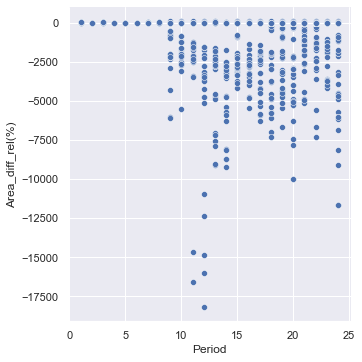

In [204]:
sns.relplot(data=df_TEST_pred_rf_grid_summary, x='Period', y='Area_diff_rel(%)');

#### NAIVE MODEL

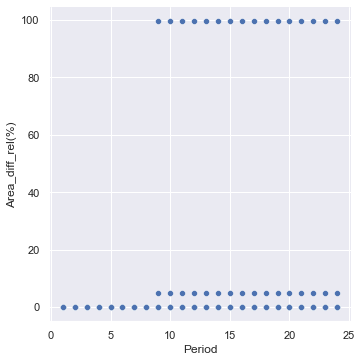

In [205]:
sns.relplot(data=df_TEST_pred_naive_summary, x='Period', y='Area_diff_rel(%)');